# Configurações iniciais

In [1]:
# LIBS
import os
import pandas as pd
import numpy as np
from scipy import stats
import dython
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import warnings 
warnings.filterwarnings('ignore') 
import seaborn as sns

# CONFIGURAÇÕES

pd.set_option('display.max_rows',100) # Ajustando número máximo de linhas a serem exibidas por dataframes
pd.set_option('display.max_columns',100) # Ajustando número máximo de colunas a serem exibidas por dataframes
pd.set_option('display.width', 100) # Ajustando tamanho a ser exibido dos valores do dataframe
pd.set_option('display.float_format', lambda x: '%.4f' % x) # Ajustando o valor dos valores floats para 4 casas decimais
%config InlineBackend.figure_format = 'retina' # Ajustando a nitidez dos gráficos
SEED = 27 # Semente para reprodução de pseudo-aleatoriedade

# DIRETÓRIOS

project_data_path = '../data' # Diretório da base de dados

# Processamento dos dados

## Conhecendo os dados

In [2]:
# Aqui faço a leitura da base de dados a partir da variável 'project_data_path', na pasta 'raw' e o arquivo 'Travel_Chalenge.csv'

df = pd.read_csv(os.path.join(project_data_path, 'raw', 'Travel_Chalenge.csv'), sep = ';')
df.sample(3) # Uma amostra aleatória de 3 registros dos dados

Airline Name Overall_Rating                  Review_Title          Review Date  \
8252    Air Arabia              1  "Staff seemed disinterested"      23rd April 2019   
10495   US Airways              1   "Take your money elsewhere"  26th September 2015   
5735      Tunisair              1      Tunisair customer review   19th November 2011   

                                                  Review Aircraft Type Of Traveller  \
8252     Gatwick to Fez. Flying to Fez, the flight wa...      NaN      Solo Leisure   
10495  When boarding the US Airways plane, I was noti...      NaN      Solo Leisure   
5735   I am very disappointed about my trip on Tunisa...      NaN               NaN   

            Seat Type           Route      Date Flown  Seat Comfort  Cabin Staff Service  \
8252    Economy Class  Gatwick to Fez      April 2019        1.0000               1.0000   
10495   Economy Class      PDX to MCI  September 2015        1.0000               1.0000   
5735   Business Class             NaN             NaN           NaN                  NaN   

       Food & Beverages  Ground Service  Inflight Entertainment  Wifi & Connectivity  
8252             1.0000          1.0000                     NaN                  NaN  
10495               NaN          2.0000                     NaN                  NaN  
5735                NaN             NaN                     NaN                  NaN

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17702 entries, 0 to 17701
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Airline Name            17702 non-null  object 
 1   Overall_Rating          17702 non-null  object 
 2   Review_Title            17702 non-null  object 
 3   Review Date             17702 non-null  object 
 4   Review                  17702 non-null  object 
 5   Aircraft                5665 non-null   object 
 6   Type Of Traveller       15953 non-null  object 
 7   Seat Type               17461 non-null  object 
 8   Route                   15876 non-null  object 
 9   Date Flown              15944 non-null  object 
 10  Seat Comfort            15456 non-null  float64
 11  Cabin Staff Service     15366 non-null  float64
 12  Food & Beverages        11924 non-null  float64
 13  Ground Service          15056 non-null  float64
 14  Inflight Entertainment  9231 non-null 

In [4]:
# Avaliando a quantidade de valores nulos e a quantidade de categorias em cada feature

for col in df.columns:
    print('-'*30)
    print('-' + col)
    print(f'Quantidade de valores nulos: {df[col].isnull().sum()}')
    print(f'Quantidade de categorias na feature: {df[col].nunique()}')
    print('-'*30)

------------------------------
-Airline Name
Quantidade de valores nulos: 0
Quantidade de categorias na feature: 182
------------------------------
------------------------------
-Overall_Rating
Quantidade de valores nulos: 0
Quantidade de categorias na feature: 10
------------------------------
------------------------------
-Review_Title
Quantidade de valores nulos: 0
Quantidade de categorias na feature: 14268
------------------------------
------------------------------
-Review Date
Quantidade de valores nulos: 0
Quantidade de categorias na feature: 3679
------------------------------
------------------------------
-Review
Quantidade de valores nulos: 0
Quantidade de categorias na feature: 17670
------------------------------
------------------------------
-Aircraft
Quantidade de valores nulos: 12037
Quantidade de categorias na feature: 835
------------------------------
------------------------------
-Type Of Traveller
Quantidade de valores nulos: 1749
Quantidade de categorias na f

In [5]:
df.duplicated().sum() # Verificando linhas duplicadas na base

np.int64(29)

## Realizando tratamentos nas colunas

### Colunas de avaliações

In [6]:
# Separando colunas referentes as avaliações dos serviços 
cols = ['Overall_Rating', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity']

In [7]:
# Verificando as categorias das colunas de avaliação do serviço

for col in cols:
    print('-'*30)
    print('-' + col)
    print(f'Quantidade de categorias na feature: {df[col].nunique()}')
    print(f'Categorias na feature: {df[col].unique()}')
    print('-'*30)

------------------------------
-Overall_Rating
Quantidade de categorias na feature: 10
Categorias na feature: ['8' '1' '9' '7' '2' '3' '6' '5' '4' 'n']
------------------------------
------------------------------
-Seat Comfort
Quantidade de categorias na feature: 6
Categorias na feature: [nan  3.  4.  0.  2.  1.  5.]
------------------------------
------------------------------
-Cabin Staff Service
Quantidade de categorias na feature: 6
Categorias na feature: [nan  4.  0.  3.  1.  5.  2.]
------------------------------
------------------------------
-Food & Beverages
Quantidade de categorias na feature: 6
Categorias na feature: [nan  4.  0.  3.  1.  5.  2.]
------------------------------
------------------------------
-Ground Service
Quantidade de categorias na feature: 5
Categorias na feature: [nan  2.  5.  1.  3.  4.]
------------------------------
------------------------------
-Inflight Entertainment
Quantidade de categorias na feature: 6
Categorias na feature: [nan  2.  0.  1.  4

Percebe-se que há alguns valores inválidos distribuídos entre as categorias das variáveis de avaliações.  
- **O quão grande é a proporção de valores na categoria inválida das avaliações?**

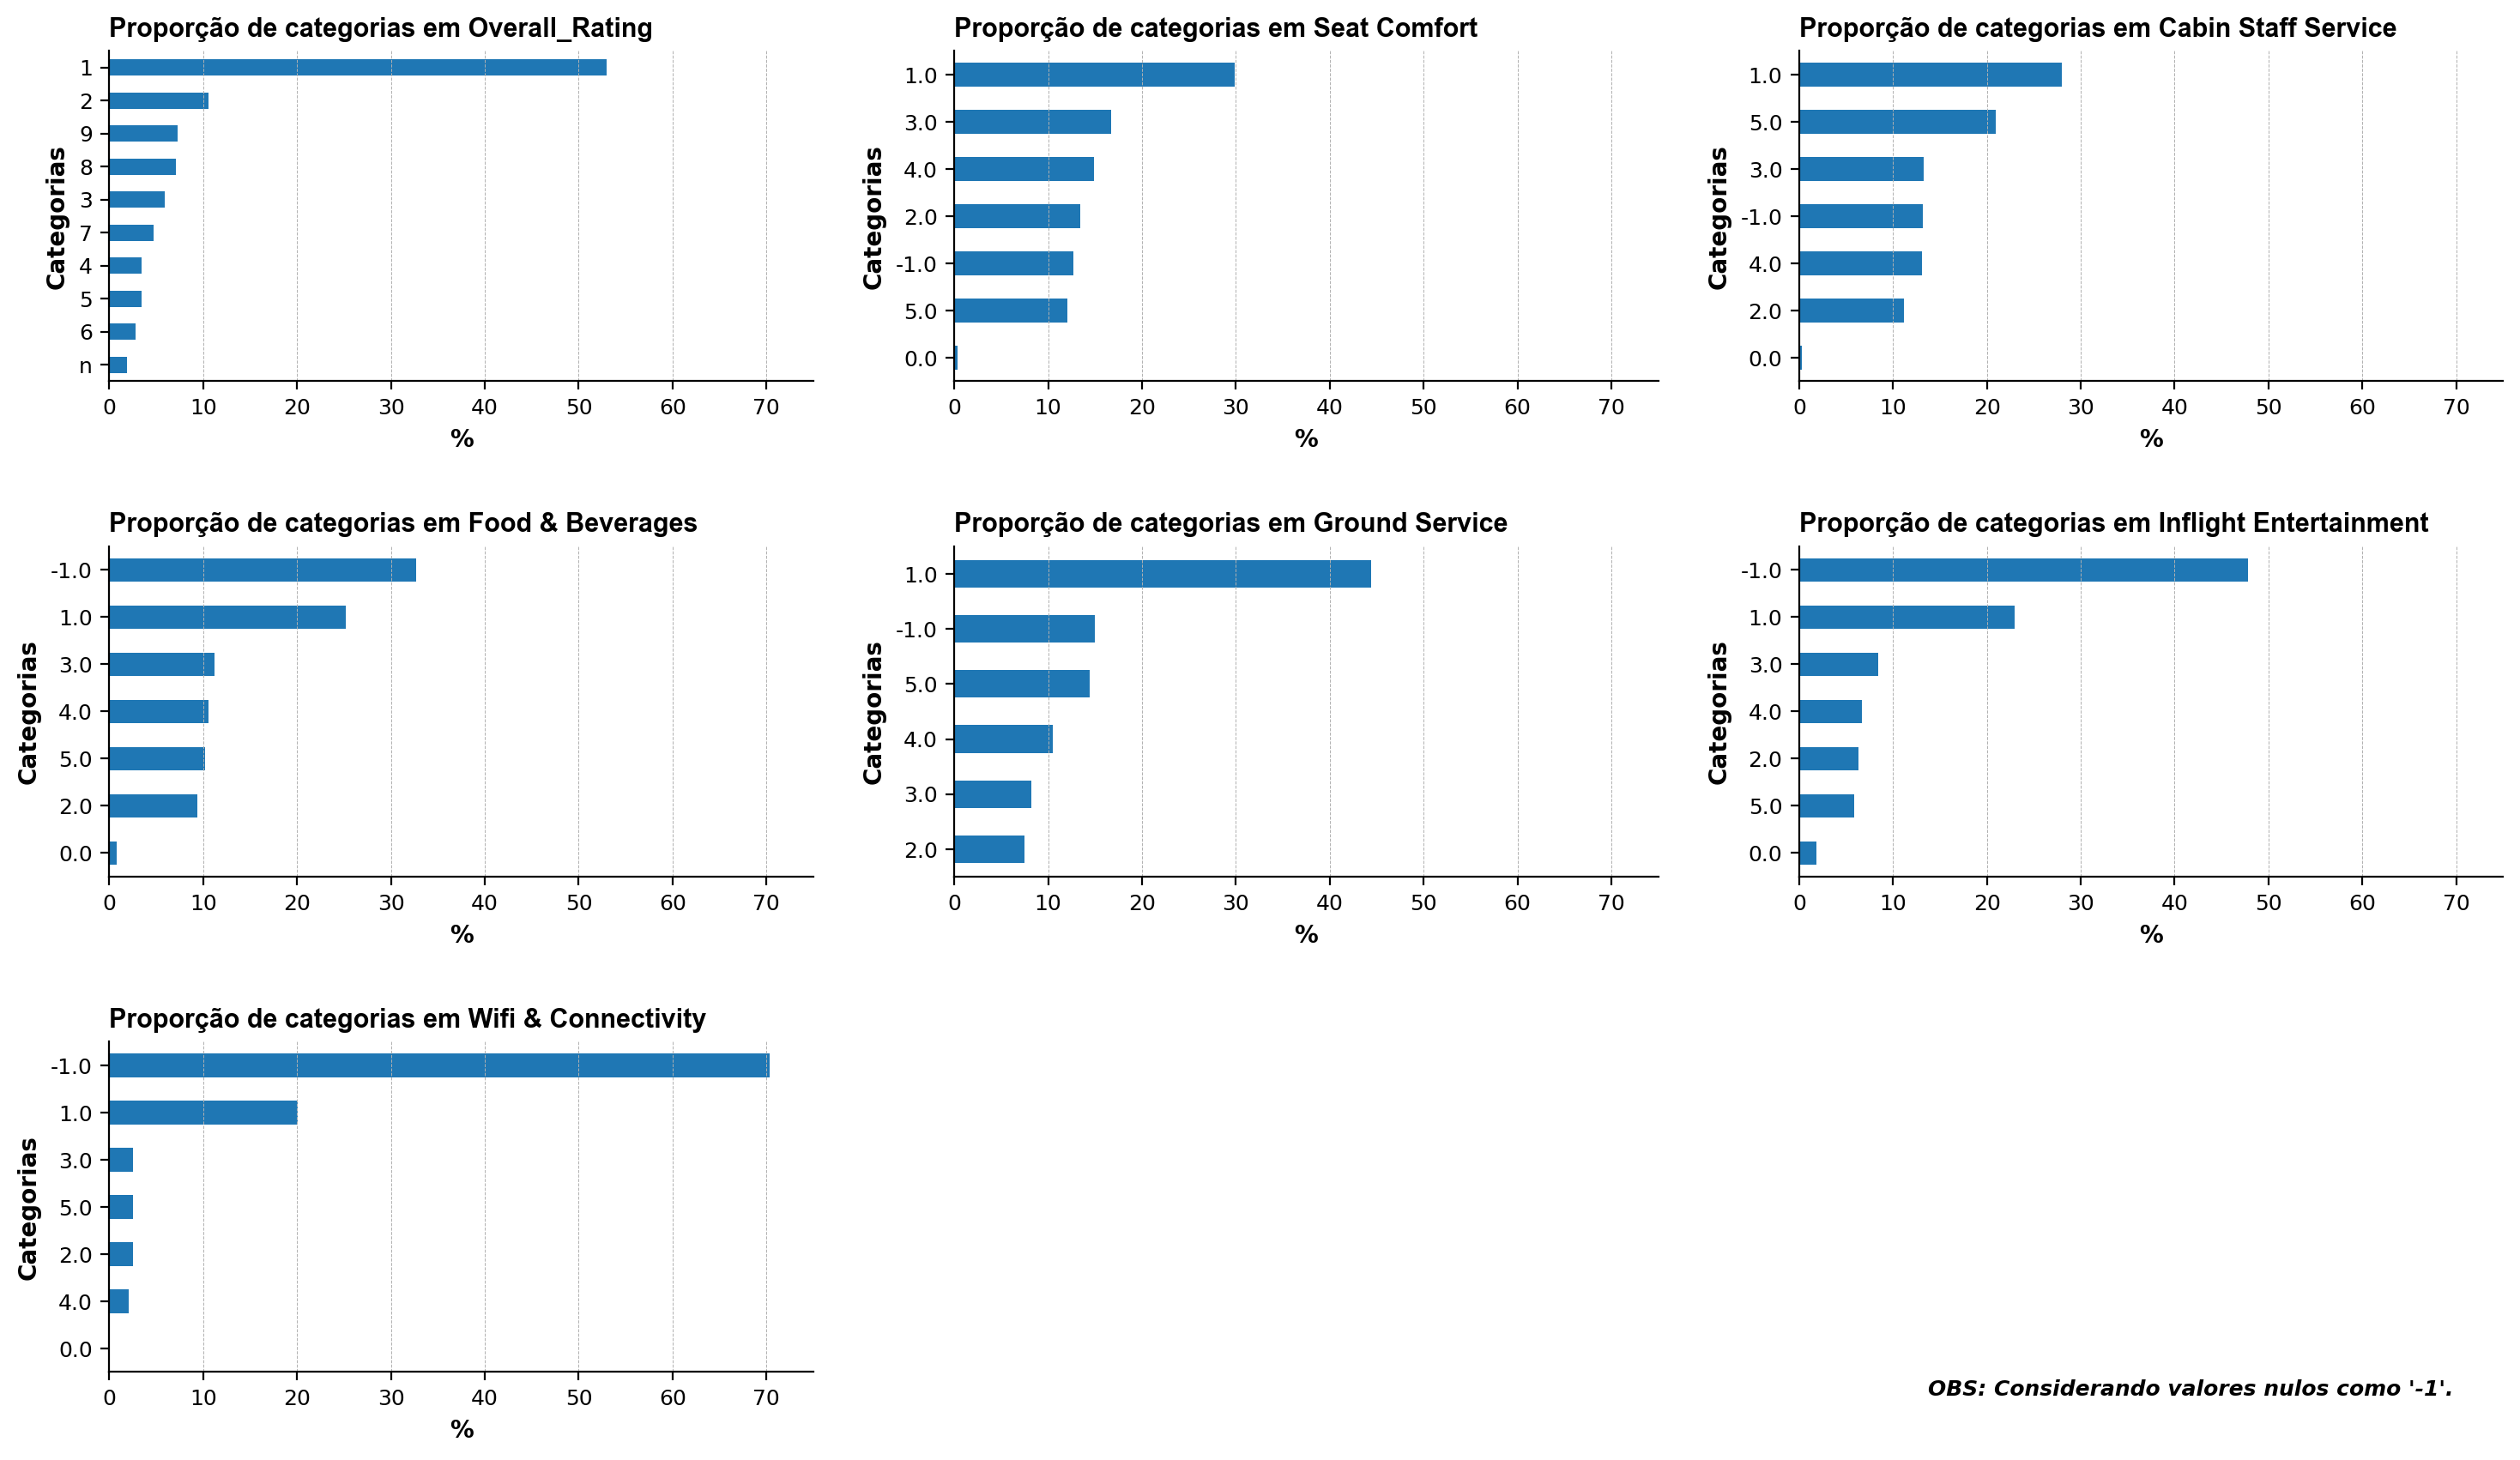

In [8]:
fig, axs = plt.subplots(3,3, figsize = (18,10))
axs = axs.reshape(3, 3)

# Considerando 'nan' como -1:

for i, col in enumerate(cols):
    row_idx = i // 3  
    col_idx = i % 3 
    
    df[col] \
        .fillna(-1) \
        .value_counts(normalize = True) \
        .apply(lambda x: x * 100) \
        .sort_values(ascending = True) \
        .plot(kind = 'barh', ax = axs[row_idx, col_idx])
    
    axs[row_idx, col_idx].set_title(f'Proporção de categorias em {col}', loc = 'left', fontsize = 11, fontfamily = 'arial', fontweight = 'bold')
    axs[row_idx, col_idx].set_ylabel('Categorias', fontweight = 'bold')
    axs[row_idx, col_idx].set_xlabel('%', fontweight = 'bold')
    axs[row_idx, col_idx].set_xlim((0,75))
    axs[row_idx, col_idx].spines['right'].set_visible(False)
    axs[row_idx, col_idx].spines['top'].set_visible(False)
    axs[row_idx, col_idx].xaxis.set_tick_params(labelsize = 9)
    axs[row_idx, col_idx].yaxis.set_tick_params(labelsize = 9)
    axs[row_idx, col_idx].grid(True, axis = 'x', linestyle='--', linewidth = .35)



for j in range(len(cols), 9):  
    row_idx = j // 3
    col_idx = j % 3
    axs[row_idx, col_idx].axis('off')


fig.text(.8, 0.1, "OBS: Considerando valores nulos como '-1'. ", ha = 'center', va = 'center', fontsize = 9, fontweight = 'bold', fontstyle = 'italic')

plt.subplots_adjust(hspace=0.5) 

É possível perceber a partir dos gráficos acima que os valores nulos estão bastante presentes nas colunas:  
- `Food & Beverages` cerca de **32%**
- `Inflight Entertainment`cerca de **48%**
- `Wifi & Connectivity` cerca de **70%**

Já as demais colunas possuem todas menos de **15%** de valores inválidos

**Decisão de tratamento**

A estratégia adotada para lidar com os dados inválidos dependerá da distribuição de frequências das categorias em cada variável, além da proporção de valores inválidos, visando perder
o mínimo de informação possível, para isso, resolvi usar as seguintes estratégias:

Para as colunas com até **15%** de valores inválidos:
- **Substituir os valores**
    - **Média**: Caso a distribução de frequências seja aproximadamente normal / simétrica
    - **Mediana ou Moda**: Caso a distribuição de frequências seja assimétrica.

Para as demais colunas (com muitos valores inválidos, acima de **40%**):
- **Substituir os valores**
    - **Mediana ou Moda**: Devido a natureza discreta das variáveis

- **Criar coluna adicional** 
    - **Marcação binária**: Se era valor inválido ou não antes do input dos valores.

Criar uma coluna adicional deve ajudar a orientar se os valores ausentes são importantes na classificação do review.

#### Inputando valores de colunas até 15% inválidos

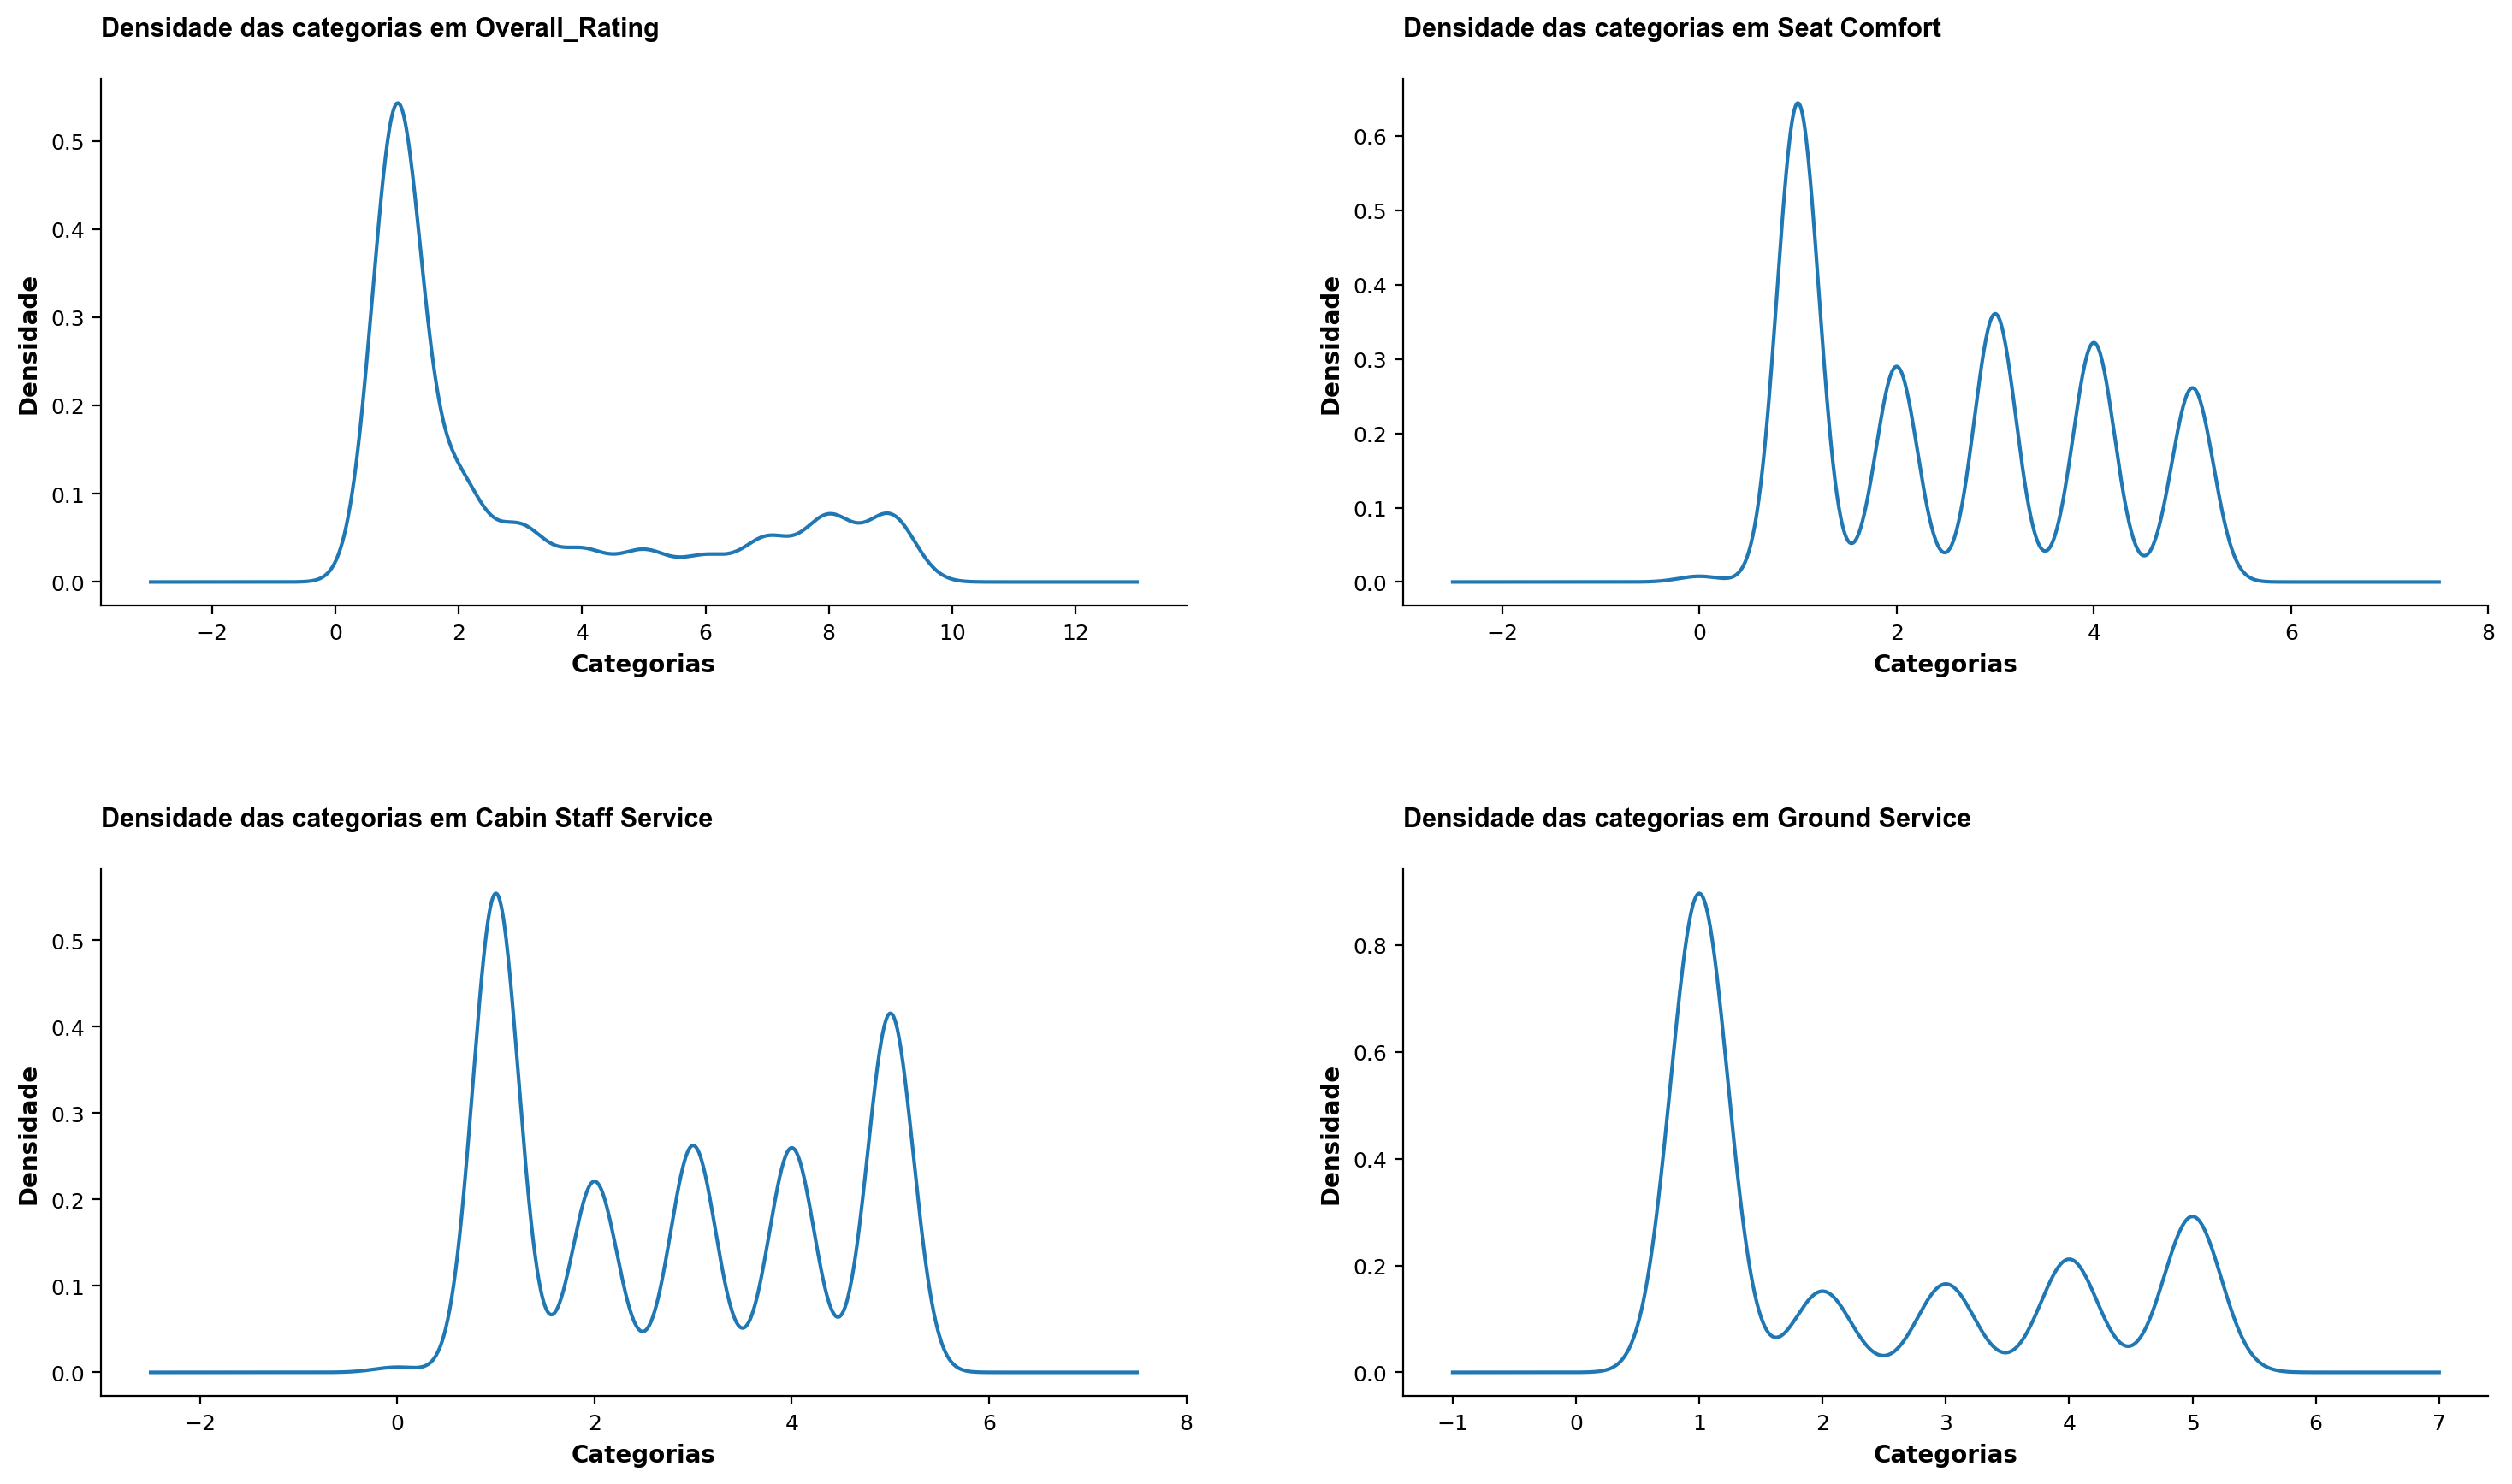

In [9]:
# Verificando distribuição aproximada das categorias nas variáveis

fig, axs = plt.subplots(2,2, figsize = (18,10))
axs = axs.reshape(2, 2)


# Selecionando colunas 
cols = ['Overall_Rating', 'Seat Comfort', 'Cabin Staff Service', 'Ground Service']


for i, col in enumerate(cols):
    row_idx = i // 2  
    col_idx = i % 2 

    if col == 'Overall_Rating':
        df[col] \
            .loc[df[col] != 'n'] \
            .astype(int) \
            .plot(kind = 'kde', ax = axs[row_idx, col_idx])
    else:
        df[col] \
            .dropna() \
            .astype(int) \
            .plot(kind = 'kde', ax = axs[row_idx, col_idx])
    
    axs[row_idx, col_idx].set_title(f'Densidade das categorias em {col} \n', loc = 'left', fontsize = 11, fontfamily = 'arial', fontweight = 'bold')
    axs[row_idx, col_idx].set_ylabel('Densidade', fontweight = 'bold')
    axs[row_idx, col_idx].set_xlabel('Categorias', fontweight = 'bold')
    axs[row_idx, col_idx].spines['right'].set_visible(False)
    axs[row_idx, col_idx].spines['top'].set_visible(False)
    axs[row_idx, col_idx].xaxis.set_tick_params(labelsize = 9)
    axs[row_idx, col_idx].yaxis.set_tick_params(labelsize = 9)



plt.subplots_adjust(hspace=0.5)  

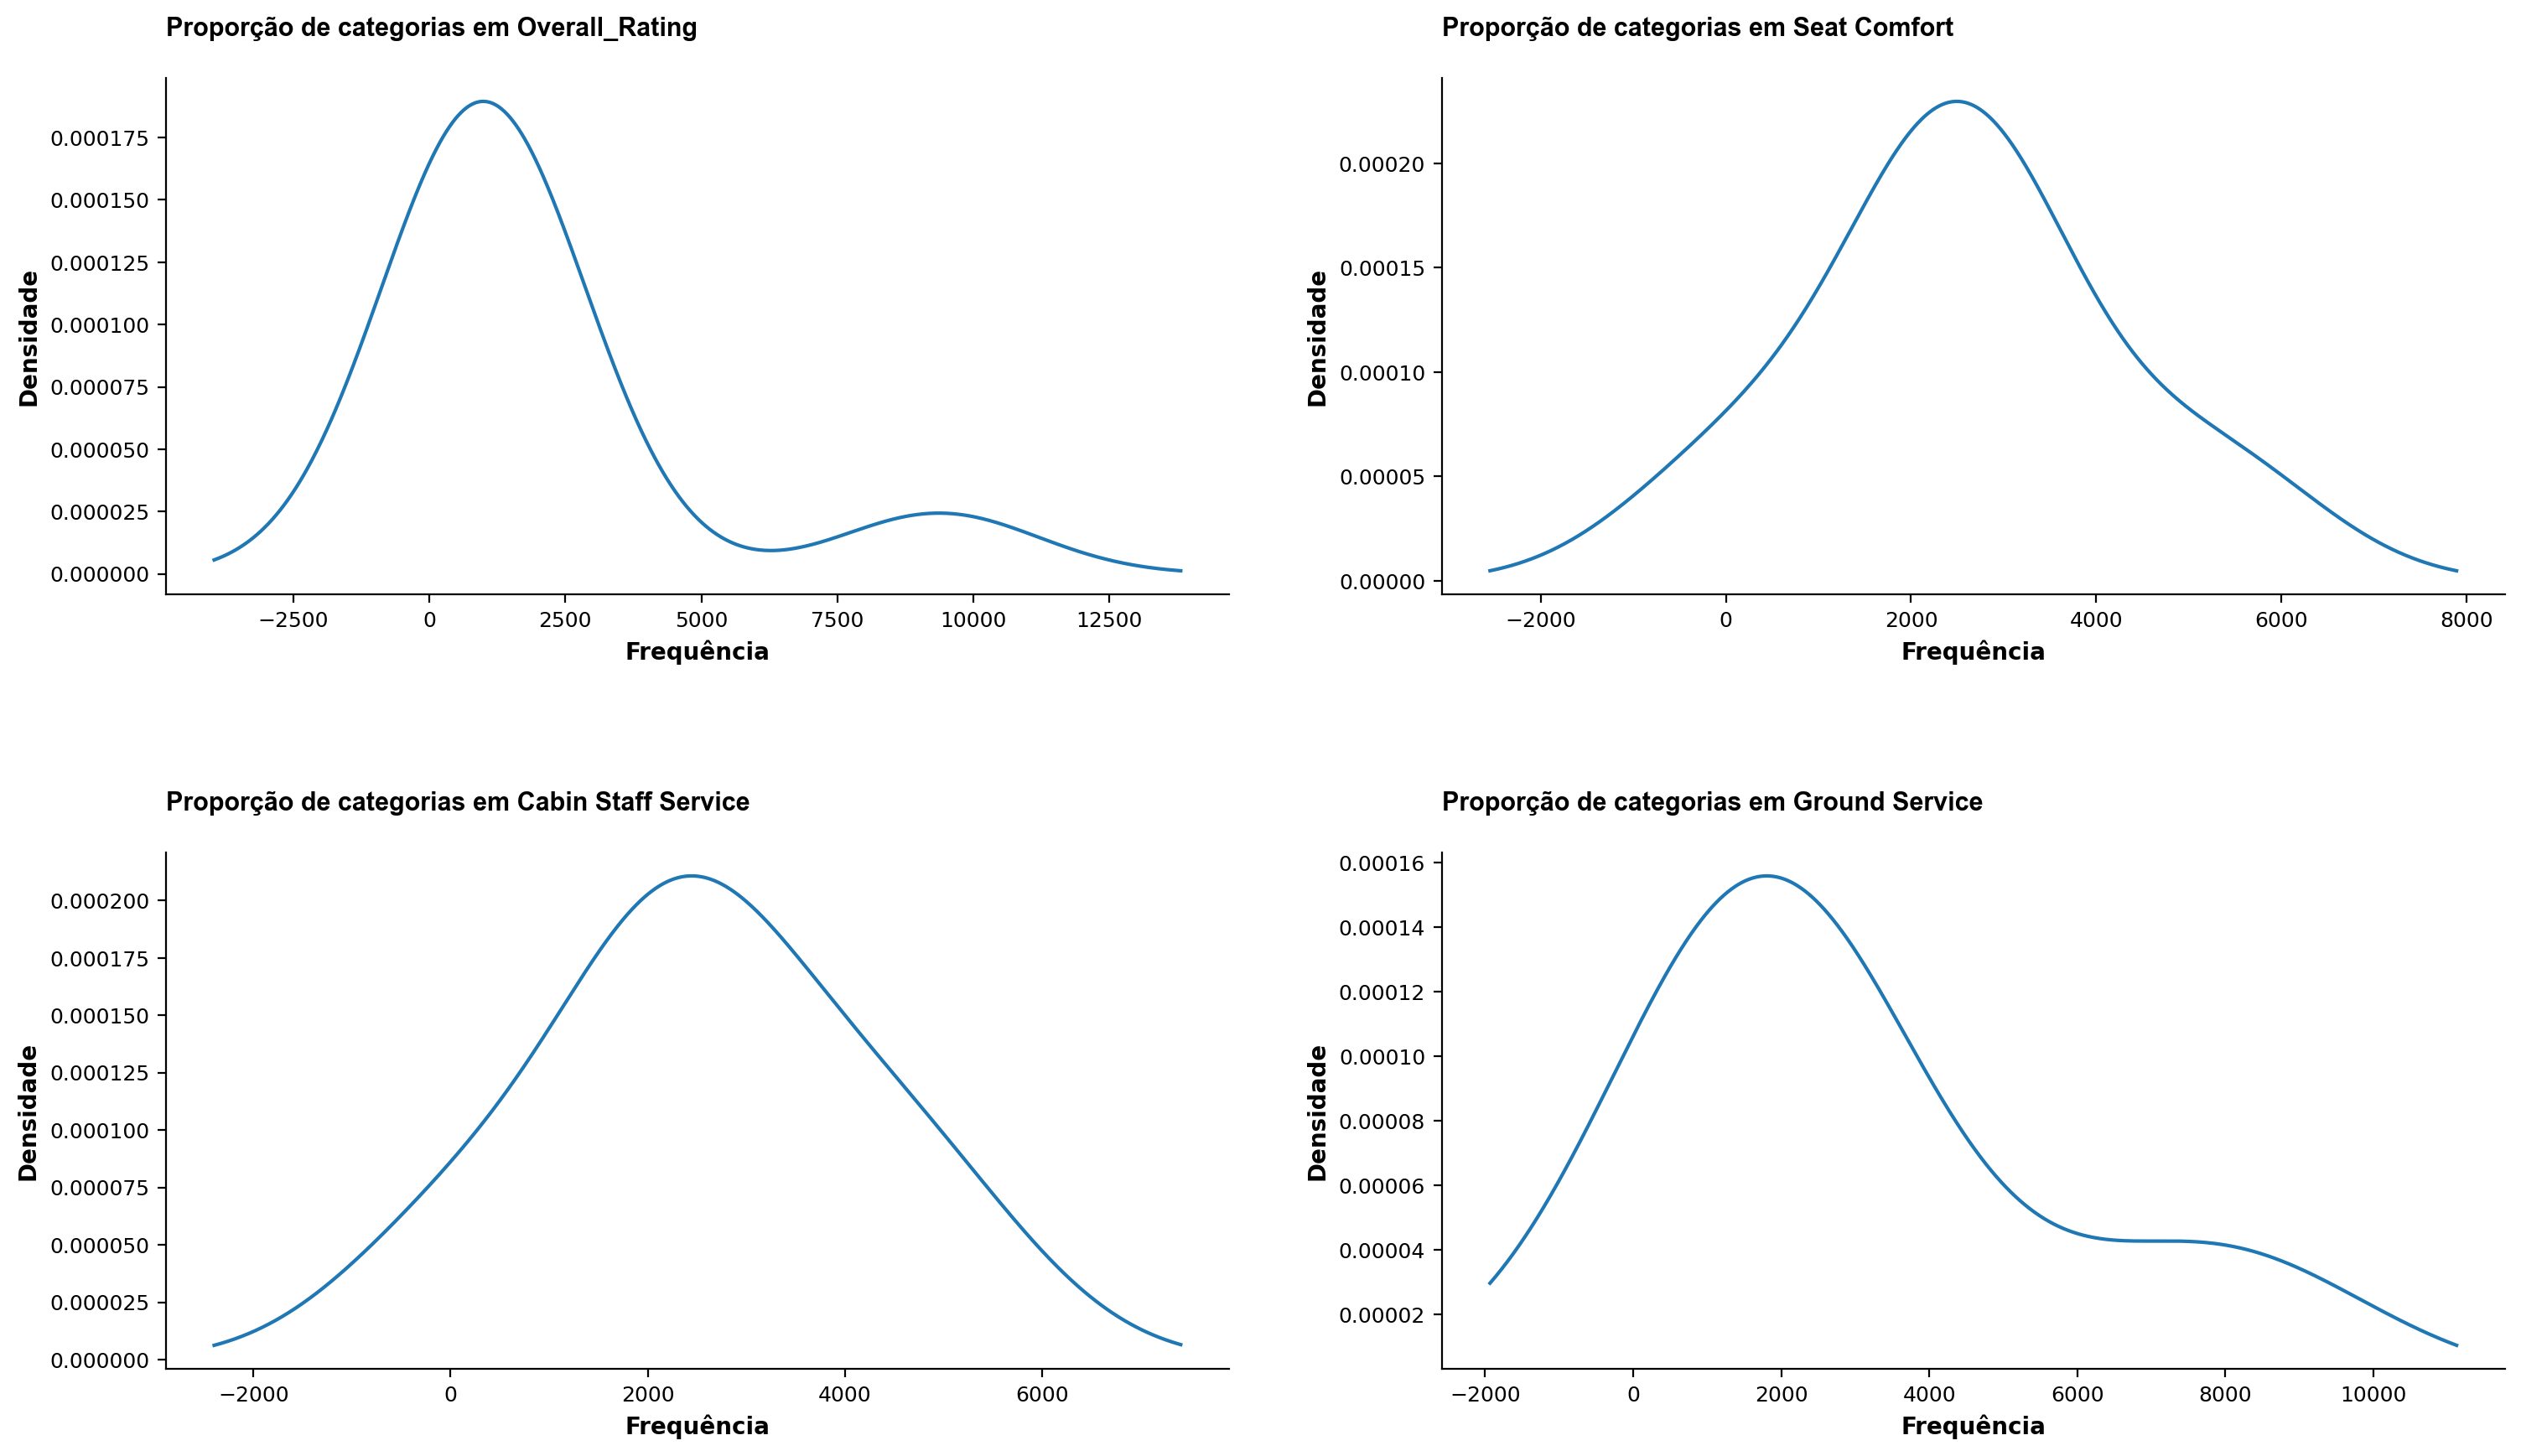

In [10]:
# Verificando distribuição aproximada das frequências das categorias

fig, axs = plt.subplots(2,2, figsize = (18,10))
axs = axs.reshape(2, 2)


# Selecionando colunas 
cols = ['Overall_Rating', 'Seat Comfort', 'Cabin Staff Service', 'Ground Service']


for i, col in enumerate(cols):
    row_idx = i // 2  
    col_idx = i % 2 

    if col == 'Overall_Rating':
        df[col] \
            .loc[df[col] != 'n'] \
            .astype(int) \
            .sort_values(ascending = True)\
            .value_counts() \
            .plot(kind = 'kde', ax = axs[row_idx, col_idx])
    else:
        df[col] \
            .dropna() \
            .astype(int) \
            .sort_values(ascending = True)\
            .value_counts() \
            .plot(kind = 'kde', ax = axs[row_idx, col_idx])
    
    axs[row_idx, col_idx].set_title(f'Proporção de categorias em {col} \n', loc = 'left', fontsize = 11, fontfamily = 'arial', fontweight = 'bold')
    axs[row_idx, col_idx].set_ylabel('Densidade', fontweight = 'bold')
    axs[row_idx, col_idx].set_xlabel('Frequência', fontweight = 'bold')
    axs[row_idx, col_idx].spines['right'].set_visible(False)
    axs[row_idx, col_idx].spines['top'].set_visible(False)
    axs[row_idx, col_idx].xaxis.set_tick_params(labelsize = 9)
    axs[row_idx, col_idx].yaxis.set_tick_params(labelsize = 9)


plt.subplots_adjust(hspace=0.5)  

A partir das visualizações anteriores, as colunas ``Seat Comfort`` e ``Cabin Staff Service`` parecem ser aproximadamente normais.
Portanto, os inputs serão dados por:
- ``Seat Comfort`` e ``Cabin Staff Service``: média
- `Overall_Rating` e `Ground Service`: mediana

In [11]:
# Inputando valores

df.loc[df['Seat Comfort'].isna(), 'Seat Comfort'] = int(df.loc[~df['Seat Comfort'].isna(), 'Seat Comfort'].astype(int).mean())
df.loc[df['Cabin Staff Service'].isna(), 'Cabin Staff Service'] = int(df.loc[~df['Cabin Staff Service'].isna(), 'Cabin Staff Service'].astype(int).mean())
df.loc[df['Overall_Rating'] == 'n', 'Overall_Rating'] = int(df.loc[df['Overall_Rating'] != 'n', 'Overall_Rating'].astype(int).median())
df.loc[df['Ground Service'].isna(), 'Ground Service'] = int(df.loc[~df['Ground Service'].isna(), 'Ground Service'].astype(int).median())

In [12]:
df.loc[df['Cabin Staff Service'].isna(), 'Cabin Staff Service'] # Verificando se ainda existem valores inválidos

Series([], Name: Cabin Staff Service, dtype: float64)

In [13]:
df.loc[df['Seat Comfort'].isna(), 'Seat Comfort'] # Verificando se ainda existem valores inválidos

Series([], Name: Seat Comfort, dtype: float64)

In [14]:
df.loc[df['Overall_Rating'].isna(), 'Overall_Rating'] # Verificando se ainda existem valores inválidos

Series([], Name: Overall_Rating, dtype: object)

In [15]:
df.loc[df['Ground Service'].isna(), 'Ground Service'] # Verificando se ainda existem valores inválidos

Series([], Name: Ground Service, dtype: float64)

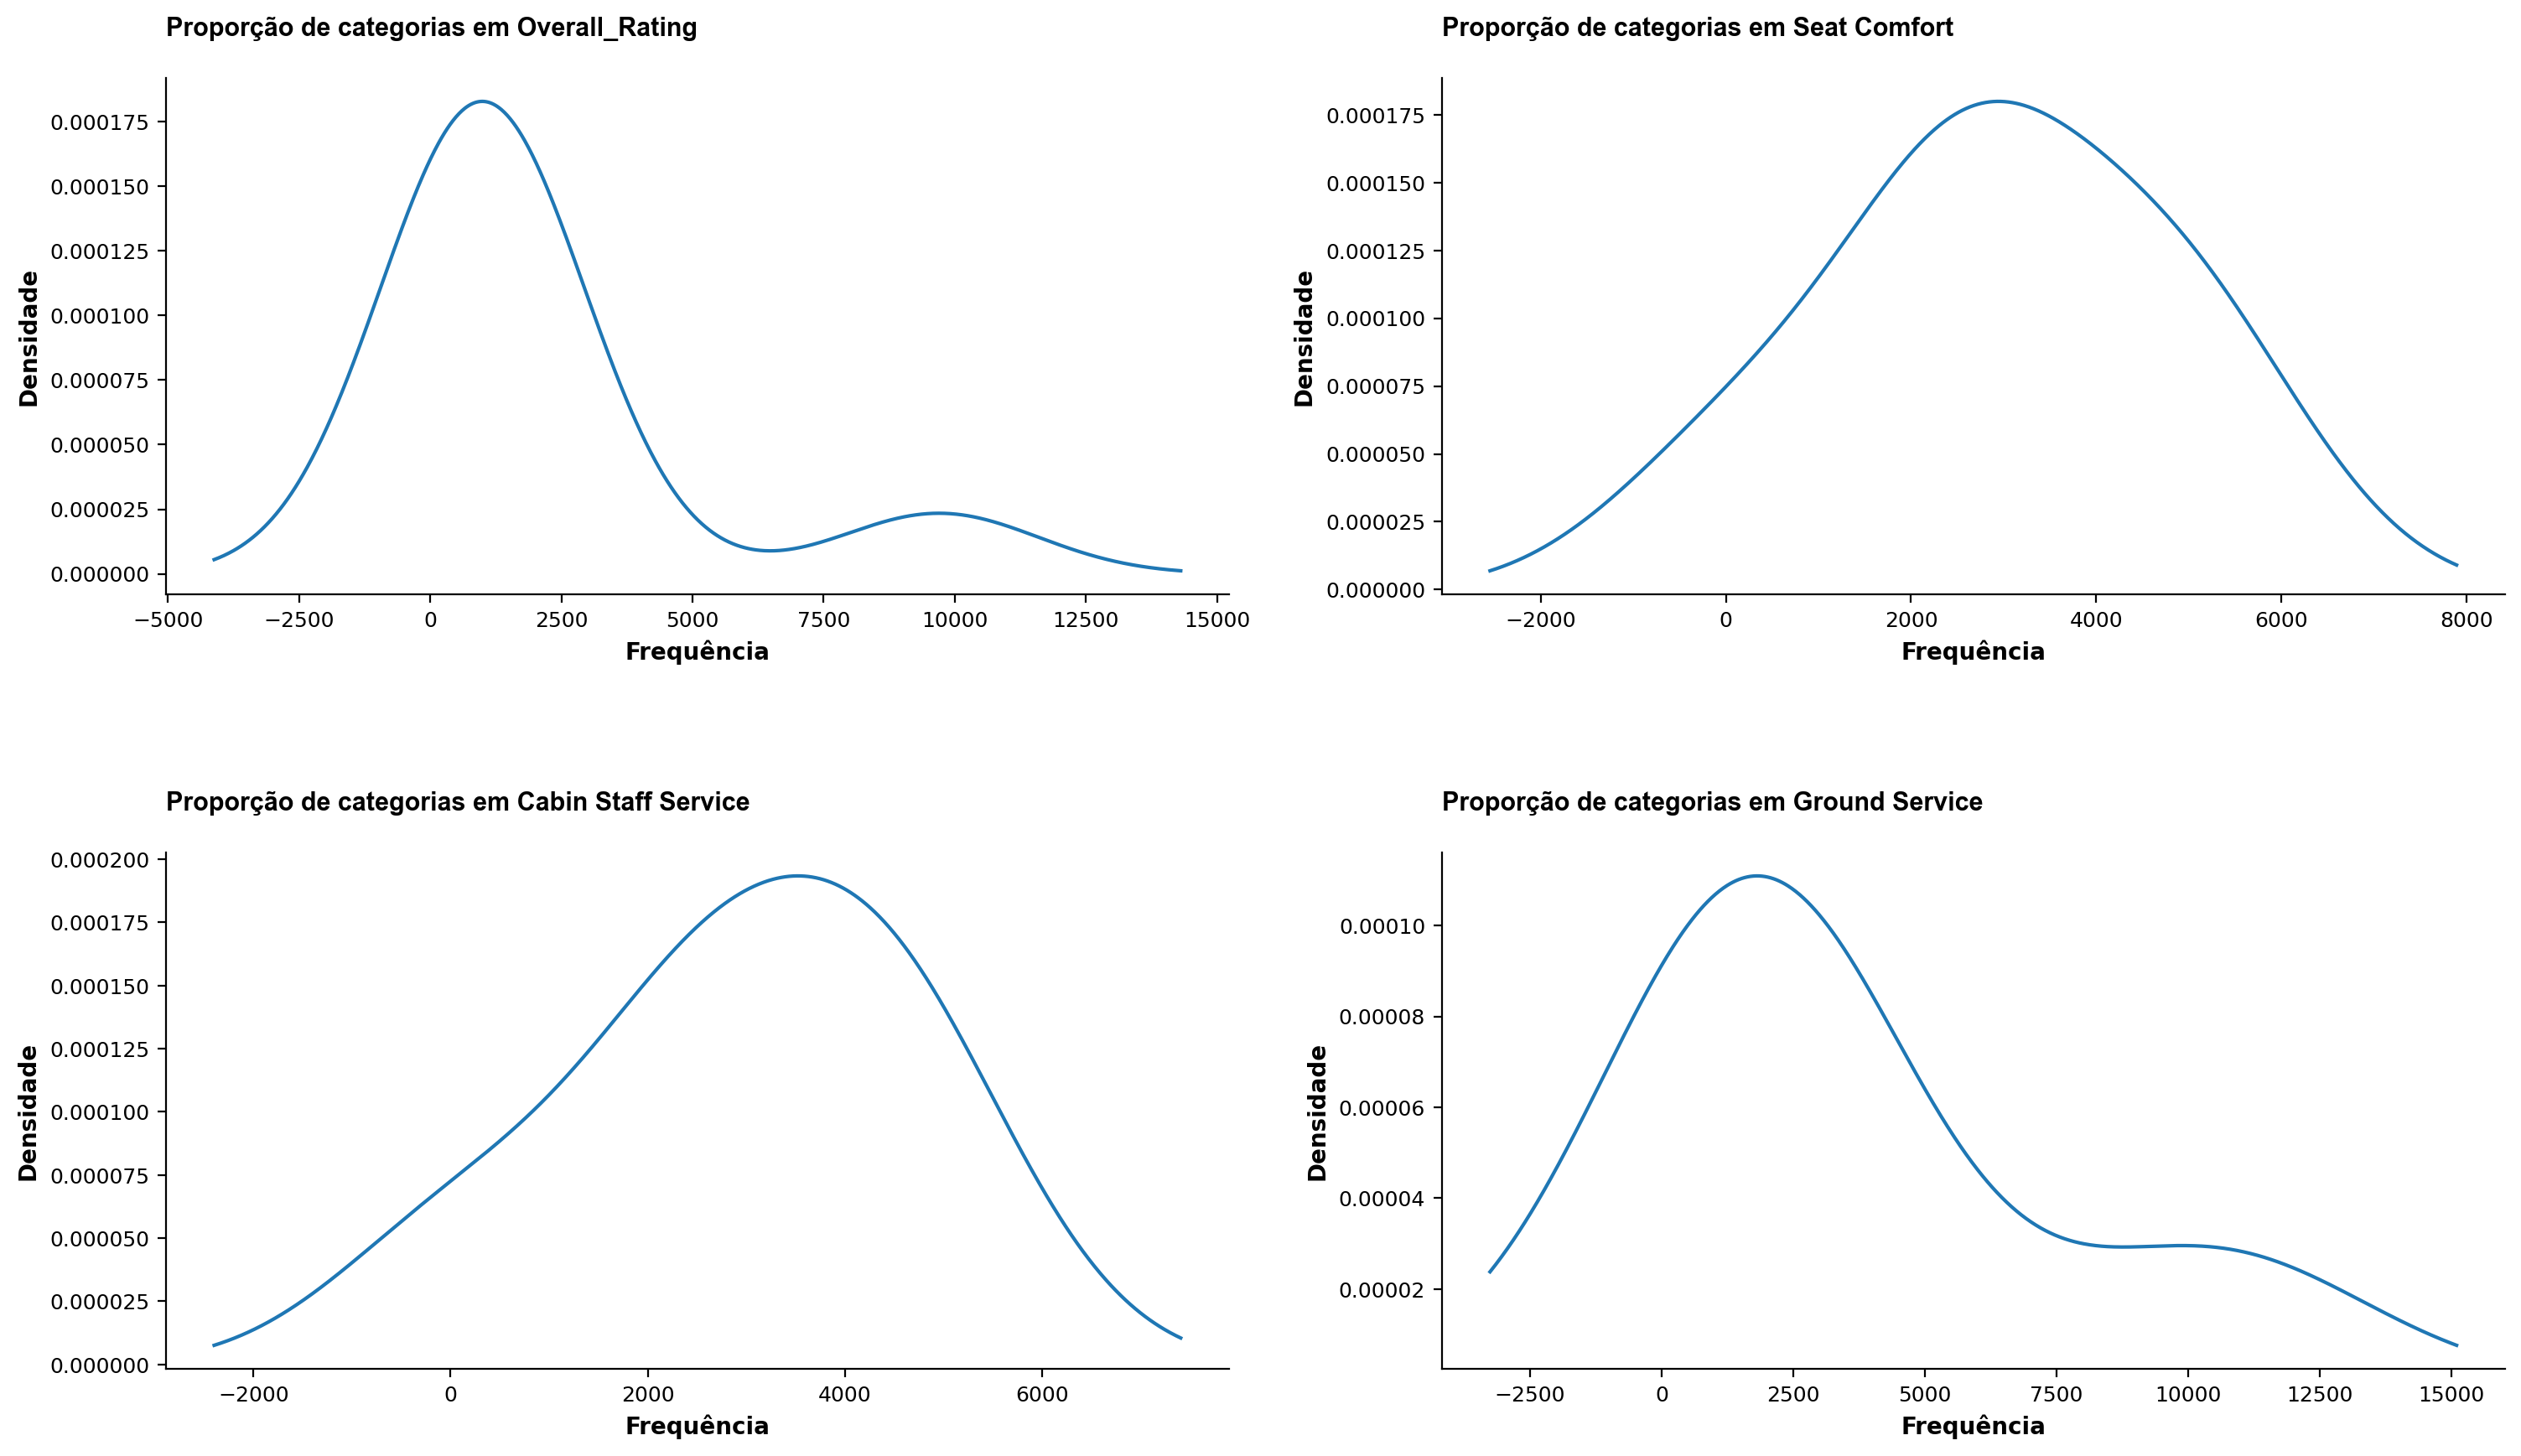

In [16]:
# Verificando o impacto do input nas distribuições

fig, axs = plt.subplots(2,2, figsize = (18,10))
axs = axs.reshape(2, 2)


# Selecionando colunas 
cols = ['Overall_Rating', 'Seat Comfort', 'Cabin Staff Service', 'Ground Service']


for i, col in enumerate(cols):
    row_idx = i // 2  
    col_idx = i % 2 

    if col == 'Overall_Rating':
        df[col] \
            .astype(int) \
            .sort_values(ascending = True)\
            .value_counts() \
            .plot(kind = 'kde', ax = axs[row_idx, col_idx])
    else:
        df[col] \
            .astype(int) \
            .sort_values(ascending = True)\
            .value_counts() \
            .plot(kind = 'kde', ax = axs[row_idx, col_idx])
    
    axs[row_idx, col_idx].set_title(f'Proporção de categorias em {col} \n', loc = 'left', fontsize = 11, fontfamily = 'arial', fontweight = 'bold')
    axs[row_idx, col_idx].set_ylabel('Densidade', fontweight = 'bold')
    axs[row_idx, col_idx].set_xlabel('Frequência', fontweight = 'bold')
    axs[row_idx, col_idx].spines['right'].set_visible(False)
    axs[row_idx, col_idx].spines['top'].set_visible(False)
    axs[row_idx, col_idx].xaxis.set_tick_params(labelsize = 9)
    axs[row_idx, col_idx].yaxis.set_tick_params(labelsize = 9)


plt.subplots_adjust(hspace=0.5)  

In [17]:
# Convertendo valores para inteiro

df['Overall_Rating'] = df['Overall_Rating'].astype(int)
df['Cabin Staff Service'] = df['Cabin Staff Service'].astype(int)
df['Ground Service'] = df['Ground Service'].astype(int)
df['Seat Comfort'] = df['Seat Comfort'].astype(int)

#### Inputando valores das demais colunas

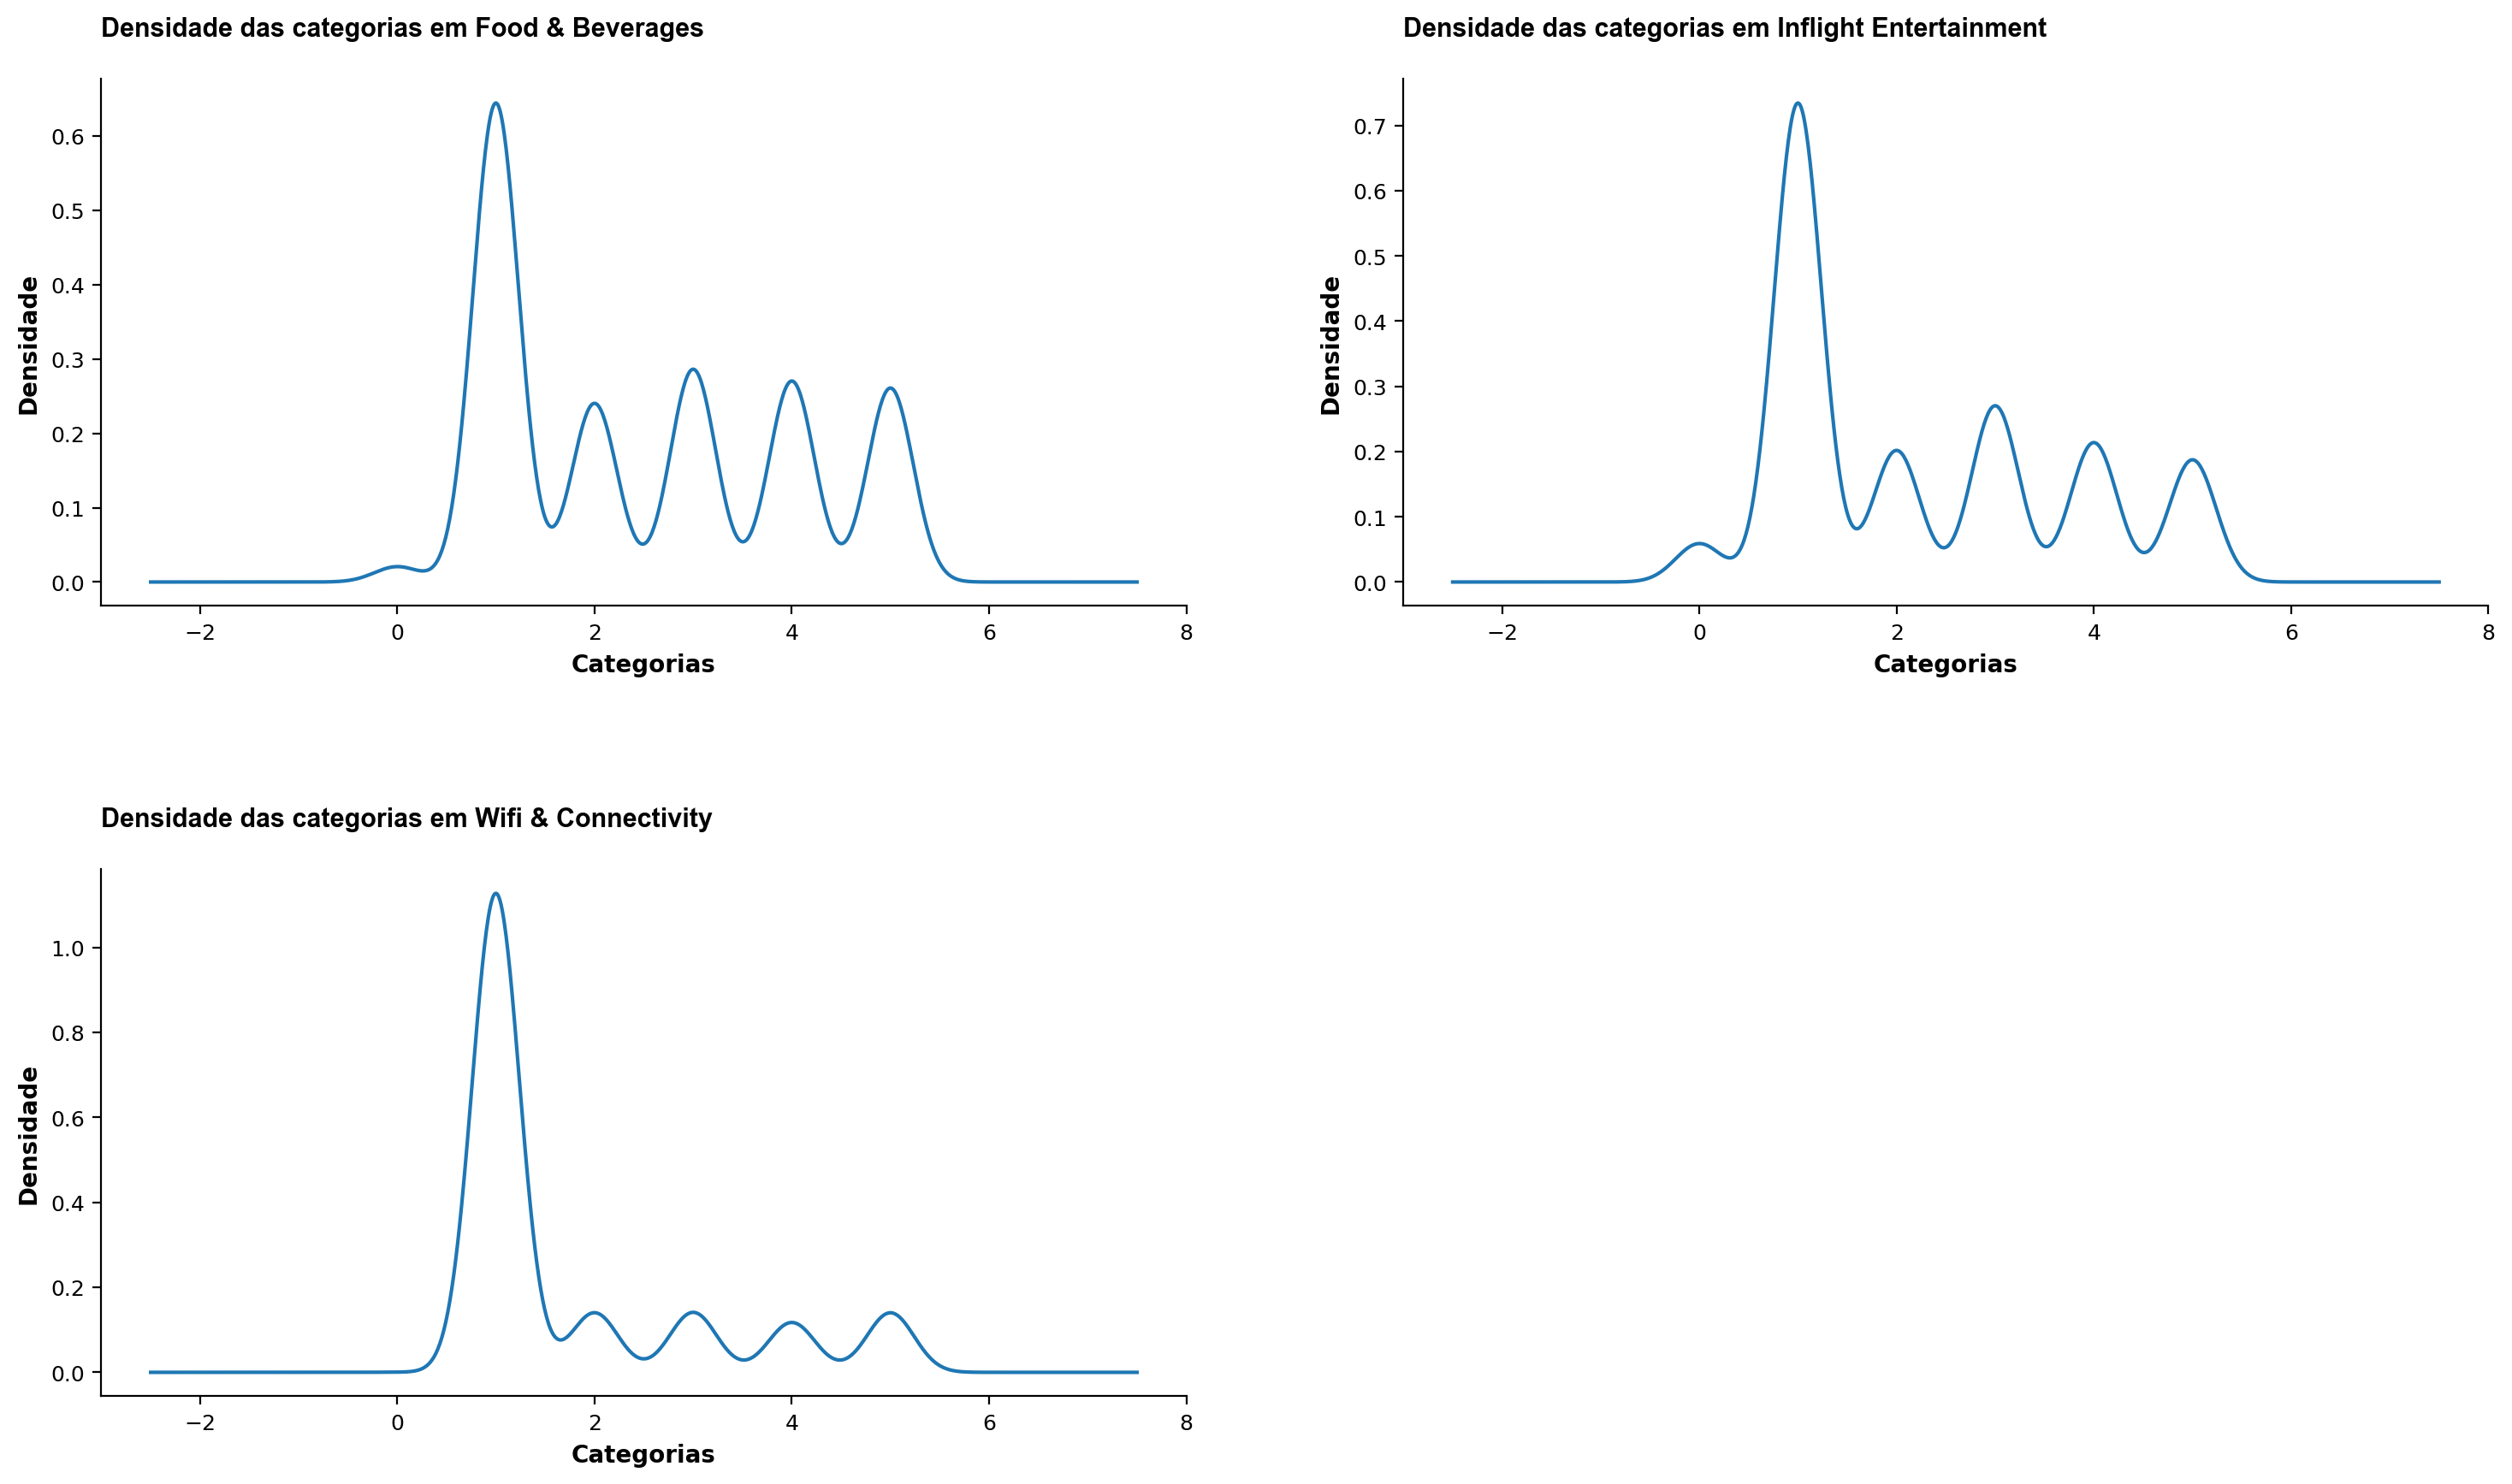

In [18]:
# Verificando distribuição aproximada das categorias nas variáveis

fig, axs = plt.subplots(2,2, figsize = (18,10))
axs = axs.reshape(2, 2)


# Selecionando colunas 
cols = ['Food & Beverages', 'Inflight Entertainment', 'Wifi & Connectivity']


for i, col in enumerate(cols):
    row_idx = i // 2  
    col_idx = i % 2 

    df[col] \
        .dropna() \
        .astype(int) \
        .plot(kind = 'kde', ax = axs[row_idx, col_idx])
    
    axs[row_idx, col_idx].set_title(f'Densidade das categorias em {col} \n', loc = 'left', fontsize = 11, fontfamily = 'arial', fontweight = 'bold')
    axs[row_idx, col_idx].set_ylabel('Densidade', fontweight = 'bold')
    axs[row_idx, col_idx].set_xlabel('Categorias', fontweight = 'bold')
    axs[row_idx, col_idx].spines['right'].set_visible(False)
    axs[row_idx, col_idx].spines['top'].set_visible(False)
    axs[row_idx, col_idx].xaxis.set_tick_params(labelsize = 9)
    axs[row_idx, col_idx].yaxis.set_tick_params(labelsize = 9)


for j in range(len(cols), 4):  
    row_idx = j // 2
    col_idx = j % 2
    axs[row_idx, col_idx].axis('off')


plt.subplots_adjust(hspace=0.5)  

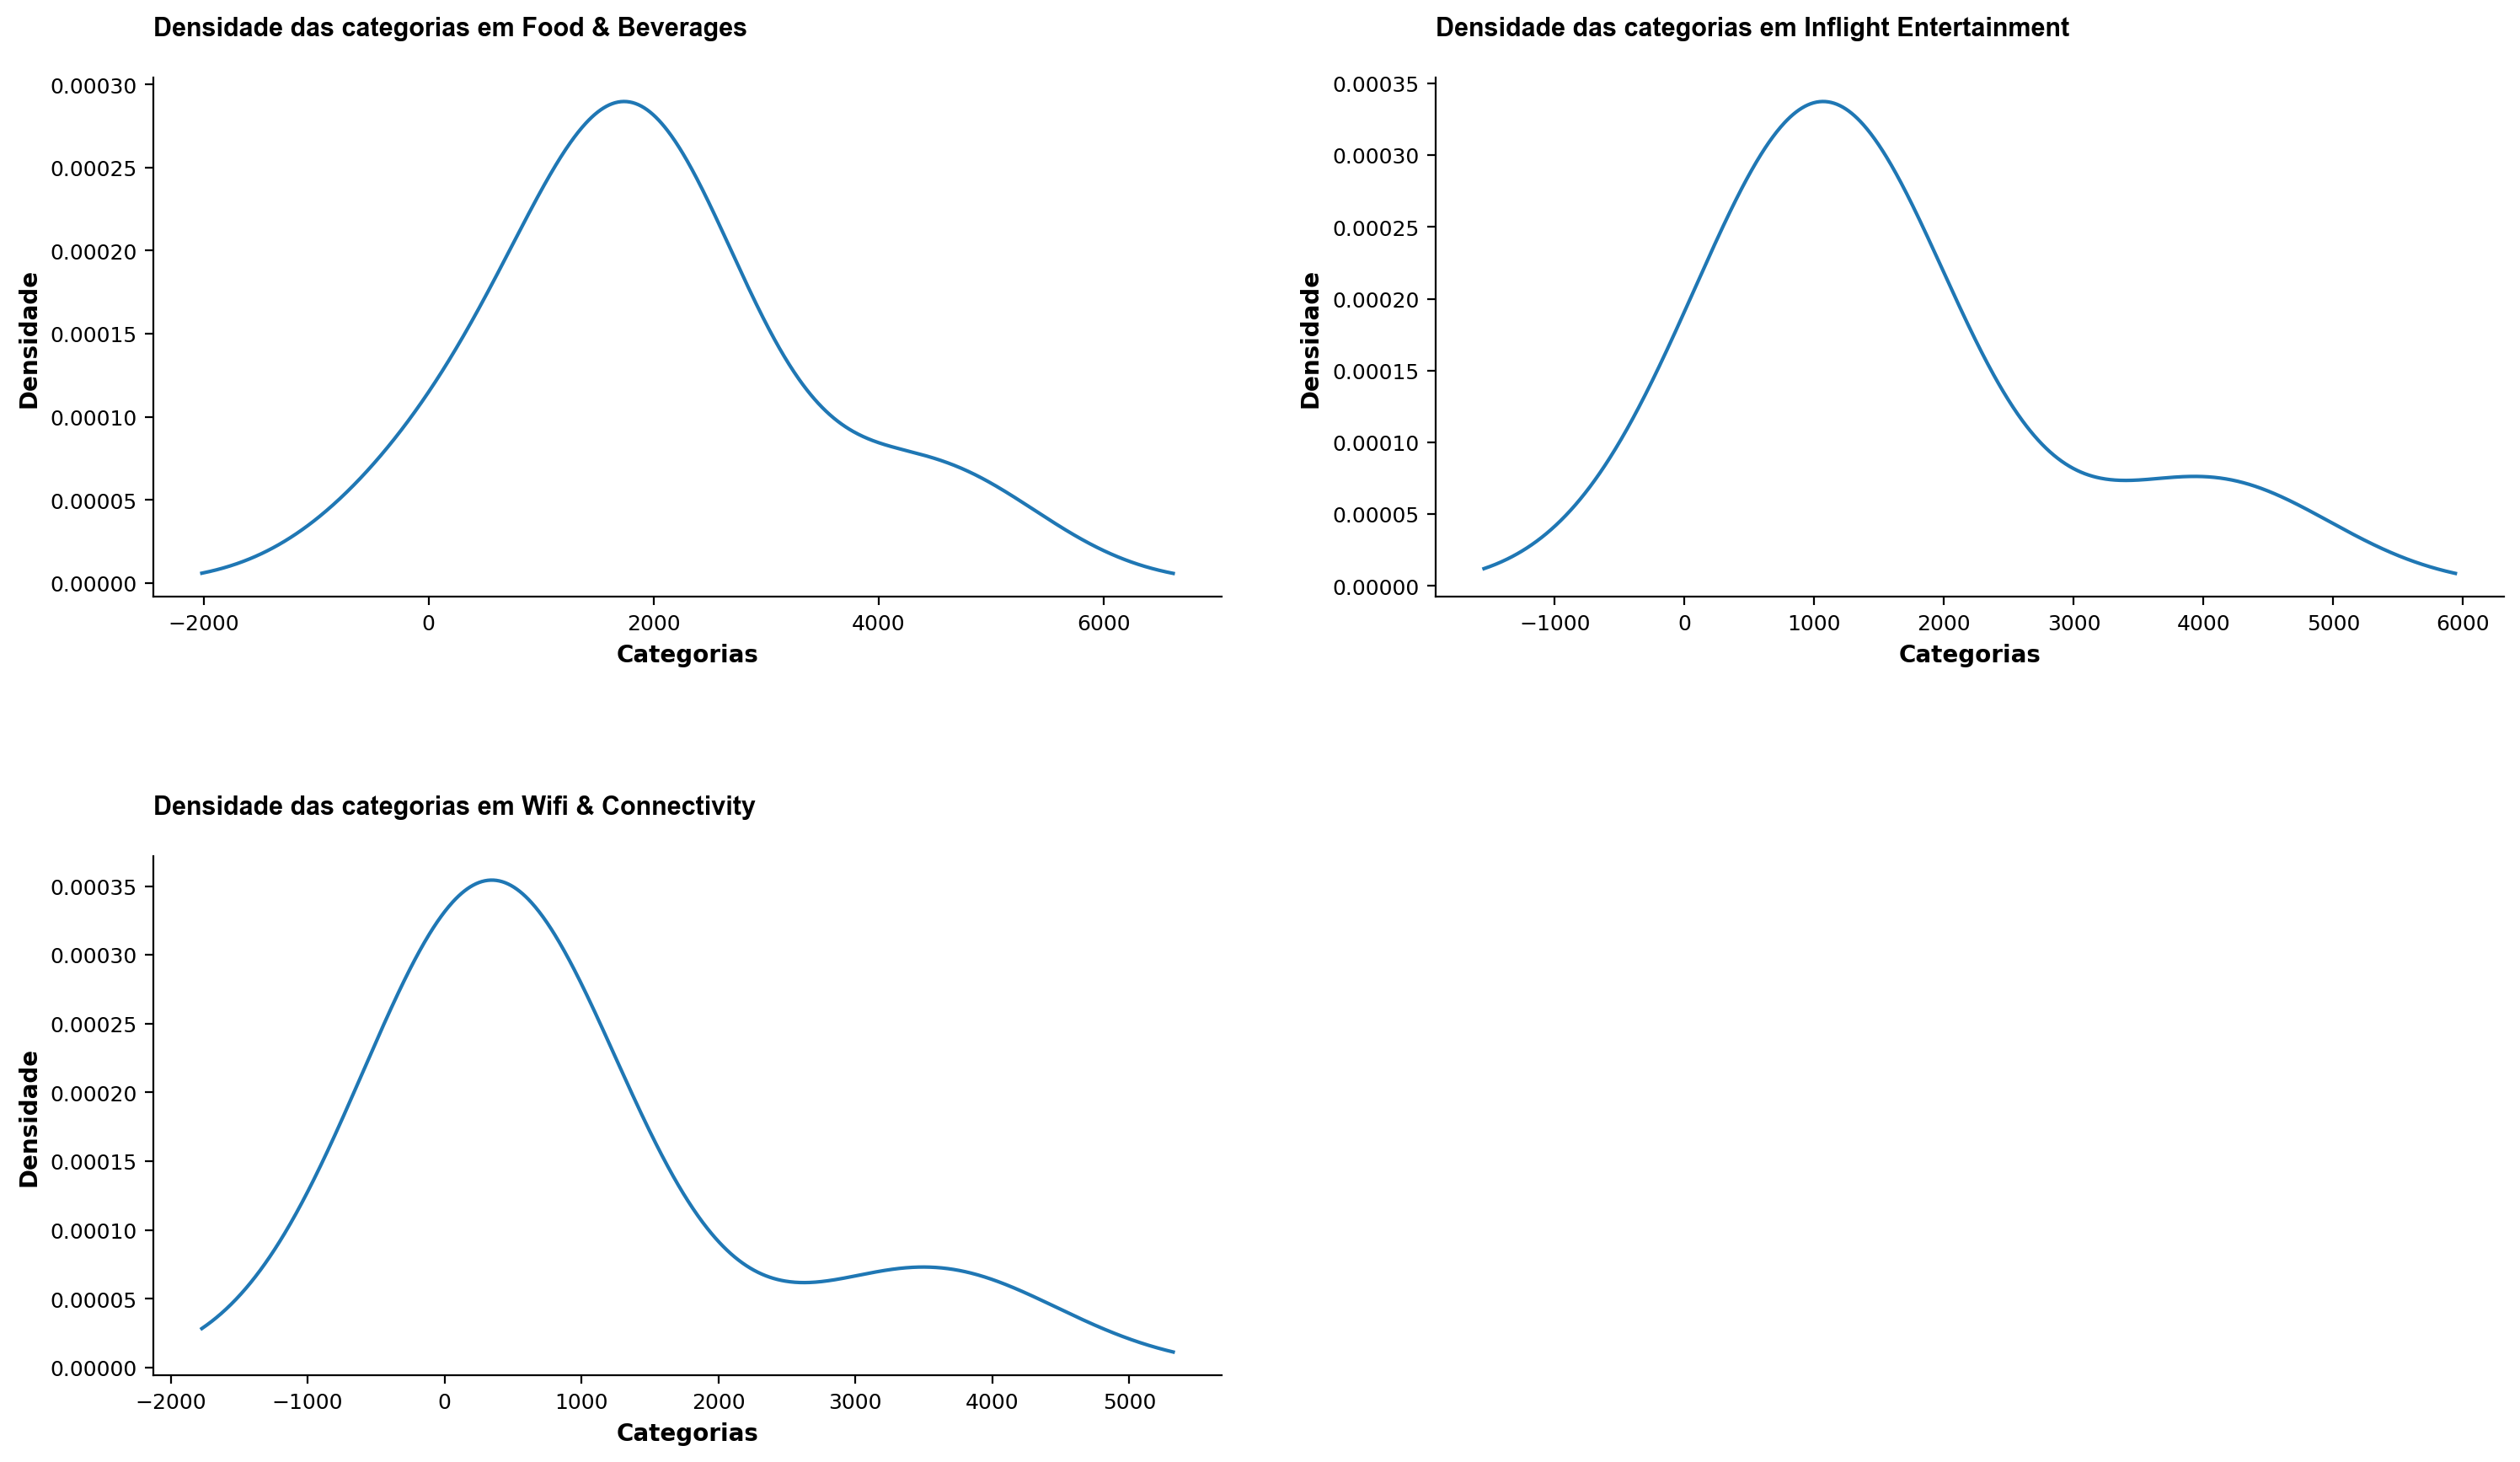

In [19]:
# Verificando distribuição aproximada das frequências das categorias

fig, axs = plt.subplots(2,2, figsize = (18,10))
axs = axs.reshape(2, 2)


# Selecionando colunas 
cols = ['Food & Beverages', 'Inflight Entertainment', 'Wifi & Connectivity']


for i, col in enumerate(cols):
    row_idx = i // 2  
    col_idx = i % 2 

    df[col] \
        .dropna() \
        .astype(int) \
        .sort_values(ascending = True)\
        .value_counts() \
        .plot(kind = 'kde', ax = axs[row_idx, col_idx])
    
    axs[row_idx, col_idx].set_title(f'Densidade das categorias em {col} \n', loc = 'left', fontsize = 11, fontfamily = 'arial', fontweight = 'bold')
    axs[row_idx, col_idx].set_ylabel('Densidade', fontweight = 'bold')
    axs[row_idx, col_idx].set_xlabel('Categorias', fontweight = 'bold')
    axs[row_idx, col_idx].spines['right'].set_visible(False)
    axs[row_idx, col_idx].spines['top'].set_visible(False)
    axs[row_idx, col_idx].xaxis.set_tick_params(labelsize = 9)
    axs[row_idx, col_idx].yaxis.set_tick_params(labelsize = 9)


for j in range(len(cols), 4):  
    row_idx = j // 2
    col_idx = j % 2
    axs[row_idx, col_idx].axis('off')

plt.subplots_adjust(hspace=0.5)  

Todas parecem possuir assimetria à direita, portanto, os seus inputs serão suas respectivas medianas

In [20]:
# Criando variáveis com marcação de valor ausente

df['FoodBeverages_isnan'] = df['Food & Beverages'].isna().astype(int)  
df['InflightEntertainment_isnan'] = df['Inflight Entertainment'].isna().astype(int)  
df['WifiConnectivity_isnan'] = df['Wifi & Connectivity'].isna().astype(int)  

In [21]:
# Inputando valores

df.loc[df['Food & Beverages'].isna(), 'Food & Beverages'] = int(df.loc[~df['Food & Beverages'].isna(), 'Food & Beverages'].astype(int).median())
df.loc[df['Inflight Entertainment'].isna(), 'Inflight Entertainment'] = int(df.loc[~df['Inflight Entertainment'].isna(), 'Inflight Entertainment'].astype(int).median())
df.loc[df['Wifi & Connectivity'].isna(), 'Wifi & Connectivity'] = int(df.loc[~df['Wifi & Connectivity'].isna(), 'Wifi & Connectivity'].astype(int).median())

In [22]:
# Convertendo para inteiro

df['Food & Beverages'] = df['Food & Beverages'].astype(int)
df['Inflight Entertainment'] = df['Inflight Entertainment'].astype(int)
df['Wifi & Connectivity'] = df['Wifi & Connectivity'].astype(int)

### Colunas de datas

In [23]:
df['Review Date'].unique() # verificando datas únicas

array(['10th April 2011', '10th April 2012', '10th April 2014', ...,
       '9th September 2020', '9th September 2021', '9th September 2022'],
      dtype=object)

In [24]:
df['Date Flown'].unique() # verificando datas únicas

array([nan, 'April 2016', 'December 2015', 'April 2017', 'March 2017',
       'March 2018', 'December 2018', 'April 2019', 'April 2020',
       'November 2019', 'March 2020', 'April 2021', 'December 2021',
       'April 2022', 'February 2023', 'April 2023', 'December 2022',
       'July 2015', 'August 2015', 'August 2017', 'July 2017',
       'June 2019', 'August 2019', 'July 2019', 'August 2020',
       'July 2020', 'June 2021', 'August 2021', 'August 2022',
       'July 2022', 'November 2015', 'December 2016', 'November 2016',
       'January 2017', 'December 2017', 'June 2018', 'November 2018',
       'December 2019', 'September 2019', 'December 2020', 'October 2020',
       'October 2022', 'November 2022', 'February 2016', 'September 2016',
       'February 2018', 'February 2019', 'February 2020', 'January 2020',
       'March 2019', 'November 2020', 'February 2021', 'February 2022',
       'January 2023', 'January 2016', 'January 2019', 'August 2018',
       'October 2019', 'Janua

In [25]:
df[df['Date Flown'].isna()].shape[0] # Possíveis voos cancelados ou datas vazias

1758

In [26]:
# Convertendo formato das colunas
## Formato %Y-%m-%d: Caso a coluna de datas possua informação sobre o dia
## Formato %Y-%m: Caso a coluna de datas não possua informação sobre o dia


def date_transform(string):
    if 'th' in string or 'rd' in string or 'st' in string or 'nd' in string:   
        return parser.parse(string).strftime('%Y-%m-%d')
    else:
        return parser.parse(string).strftime('%Y-%m')        

In [27]:
df.insert(4, 'Review_Date_conv', df['Review Date'].apply(date_transform)) # Adicionando nova coluna com data convertida
df.sample(3)

Airline Name  Overall_Rating                       Review_Title         Review Date  \
9470     Insel Air               1          "Treated us like garbage"  25th February 2017   
12745    Eurowings               7  "premium economy was quite comfy"   2nd November 2022   
7508    Air Berlin               1   "never fly with airberlin again"       21st May 2017   

      Review_Date_conv                                             Review  Aircraft  \
9470        2017-02-25    Port of Spain to Willemstad. Please don't pu...       NaN   
12745       2022-11-02    Eurowings Discover flight was very Smooth. D...  A330-200   
7508        2017-05-21    Munich to Stockholm via Dusseldorf. Horrible...      A320   

      Type Of Traveller        Seat Type                               Route     Date Flown  \
9470     Family Leisure    Economy Class         Port of Spain to Willemstad  February 2017   
12745    Couple Leisure  Premium Economy            Frankfurt to Panama City   October 2022   
7508           Business    Economy Class  Munich to Stockholm via Dusseldorf       May 2017   

       Seat Comfort  Cabin Staff Service  Food & Beverages  Ground Service  \
9470              1                    1                 2               1   
12745             5                    5                 4               5   
7508              4                    1                 2               1   

       Inflight Entertainment  Wifi & Connectivity  FoodBeverages_isnan  \
9470                        2                    1                    1   
12745                       4                    1                    0   
7508                        2                    1                    1   

       InflightEntertainment_isnan  WifiConnectivity_isnan  
9470                             1                       1  
12745                            0                       1  
7508                             1                       0

In [28]:
df.insert(11, 'Date_Flown_conv', df.loc[df['Date Flown'].notna(), 'Date Flown'].apply(date_transform)) # Adicionando nova coluna com data convertida
df.sample(3)

Airline Name  Overall_Rating                    Review_Title         Review Date  \
7046      Volotea               1     "Excellent value for money"   20th October 2022   
3576   Air Serbia               2  "trying to get the money back"  16th February 2023   
1756      easyJet               1          "trouble-free journey"     13th April 2023   

     Review_Date_conv                                             Review  Aircraft  \
7046       2022-10-20    We traveled with Volotea in September from O...       NaN   
3576       2023-02-16    I paid for 2 extra suitcases online and was ...       NaN   
1756       2023-04-13    No complaints. Smooth and attentive service ...  A320 neo   

     Type Of Traveller      Seat Type                            Route      Date Flown  \
7046    Family Leisure  Economy Class                   Olbia to Milan  September 2022   
3576      Solo Leisure  Economy Class  Stuttgart to Malta via Belgrade   February 2023   
1756      Solo Leisure    First Class                 Luton to Larnaca      April 2023   

     Date_Flown_conv  Seat Comfort  Cabin Staff Service  Food & Beverages  Ground Service  \
7046         2022-09             5                    5                 5               5   
3576         2023-02             2                    3                 1               1   
1756         2023-04             5                    5                 5               5   

      Inflight Entertainment  Wifi & Connectivity  FoodBeverages_isnan  \
7046                       1                    1                    0   
3576                       1                    1                    0   
1756                       2                    1                    0   

      InflightEntertainment_isnan  WifiConnectivity_isnan  
7046                            0                       1  
3576                            0                       0  
1756                            1                       1

In [29]:
df['Date_Flown_conv'].fillna(pd.to_datetime('1900-01', format = '%Y-%m'), inplace=True) # Inserindo "data coringa" em datas inválidas

In [30]:
# df['Date_Flown_conv'].dt.strftime('%Y-%m')

In [31]:
df['Review_Date_conv'] = pd.to_datetime(df['Review_Date_conv'], format = '%Y-%m-%d') # Convertendo para datetime
df['Date_Flown_conv'] = pd.to_datetime(df['Date_Flown_conv'], errors = 'coerce').dt.strftime('%Y-%m') # Convertendo para datetime

In [32]:
df.drop(columns = ['Review Date', 'Date Flown'], inplace = True) # Excluindo colunas de datas desformatadas

In [33]:
df['Review_Date_conv'].min(), df['Review_Date_conv'].max()

(Timestamp('2002-08-25 00:00:00'), Timestamp('2023-07-27 00:00:00'))

## Nulos

In [34]:
df.isnull().sum() 

Airline Name                       0
Overall_Rating                     0
Review_Title                       0
Review_Date_conv                   0
Review                             0
Aircraft                       12037
Type Of Traveller               1749
Seat Type                        241
Route                           1826
Date_Flown_conv                    0
Seat Comfort                       0
Cabin Staff Service                0
Food & Beverages                   0
Ground Service                     0
Inflight Entertainment             0
Wifi & Connectivity                0
FoodBeverages_isnan                0
InflightEntertainment_isnan        0
WifiConnectivity_isnan             0
dtype: int64

In [35]:
# Adicionando "string coringa" para valores inválidos

df.loc[df['Aircraft'].isna(), 'Aircraft'] = 'No Info'
df.loc[df['Type Of Traveller'].isna(), 'Type Of Traveller'] = 'No Info'
df.loc[df['Seat Type'].isna(), 'Seat Type'] = 'No Info'
df.loc[df['Route'].isna(), 'Route'] = 'No Info'

## Duplicadas

In [36]:
df[df.duplicated()].shape[0] # Quantidade de linhas duplicadas

29

In [37]:
df[df.duplicated()]

Airline Name  Overall_Rating                   Review_Title Review_Date_conv  \
514    Edelweiss Air               1  Edelweiss Air customer review       2003-09-10   
516           Kulula               1         Kulula customer review       2006-09-10   
1065          Luxair               1         Luxair customer review       2004-10-11   
1352          Luxair               4         Luxair customer review       2007-07-12   
1549          Kulula               1         Kulula customer review       2007-05-12   
2034          Luxair               1         Luxair customer review       2006-03-13   
2074          Luxair               1         Luxair customer review       2007-05-13   
2904          Luxair               1         Luxair customer review       2006-12-15   
3178          Kulula               1         Kulula customer review       2006-03-15   
4441          Luxair               1         Luxair customer review       2004-05-17   
4755   Edelweiss Air               1  Edelweiss Air customer review       2006-02-18   
5911          Luxair               1         Luxair customer review       2004-08-01   
6239          Luxair               1         Luxair customer review       2007-03-01   
8016          Luxair               1         Luxair customer review       2005-03-22   
8136          Kulula               1         Kulula customer review       2006-11-22   
8768          Kulula               1         Kulula customer review       2006-09-23   
9190          Luxair               1         Luxair customer review       2006-05-24   
10448         Luxair               1         Luxair customer review       2005-10-26   
11180  Edelweiss Air               1  Edelweiss Air customer review       2003-08-28   
11182         Kulula               1         Kulula customer review       2005-08-28   
11395  Edelweiss Air               1  Edelweiss Air customer review       2005-06-28   
12191         Luxair               5         Luxair customer review       2007-09-29   
12447         Luxair               1         Luxair customer review       2005-07-02   
12831         Luxair               1         Luxair customer review       2004-04-30   
13162  Edelweiss Air               1  Edelweiss Air customer review       2004-05-30   
14073         Luxair               1         Luxair customer review       2007-03-03   
14939         Luxair               1         Luxair customer review       2004-08-05   
17461         Kulula               1         Kulula customer review       2006-06-09   
17544         Luxair               1         Luxair customer review       2006-05-09   

                                                  Review Aircraft Type Of Traveller Seat Type  \
514    I flew Edelweiss to Antalya a couple of days a...  No Info           No Info   No Info   
516    Great airline with its excellent prices and ca...  No Info           No Info   No Info   
1065   Economy from Manchester to Luxembourg. Very ni...  No Info           No Info   No Info   
1352   LUX-CDG on a ERJ and back on new Q400. As alwa...  No Info           No Info   No Info   
1549   Cape Town to Johannesburg. Very cheap ticket w...  No Info           No Info   No Info   
2034   Dublin-Manchester. Missed a flight with anothe...  No Info           No Info   No Info   
2074   Mixed feelings about Luxair. Onboard service i...  No Info           No Info   No Info   
2904   Man-Dublin on CRJ-145. Very comfy seats in lig...  No Info           No Info   No Info   
3178   On our honeymoon to SA we flew Kulula from Dur...  No Info           No Info   No Info   
4441   I take Luxair many times and I'am always pleas...  No Info           No Info   No Info   
4755   EDW ZRH-CLB-MLE on the 6th feb. and MLE-ZRH on...  No Info           No Info   No Info   
5911   I spend at least the half of my time during a ...  No Info           No Info   No Info   
6239   Have travelled Luxair (Dub-Man-Lux) several ti...  No Info           No Info   No Info   
8016   I 

In [38]:
df = df[~df.duplicated()] # Retirando duplicadas

In [39]:
df.info() # Informações sobre o DataFrame tratado

<class 'pandas.core.frame.DataFrame'>
Index: 17673 entries, 0 to 17701
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Airline Name                 17673 non-null  object        
 1   Overall_Rating               17673 non-null  int64         
 2   Review_Title                 17673 non-null  object        
 3   Review_Date_conv             17673 non-null  datetime64[ns]
 4   Review                       17673 non-null  object        
 5   Aircraft                     17673 non-null  object        
 6   Type Of Traveller            17673 non-null  object        
 7   Seat Type                    17673 non-null  object        
 8   Route                        17673 non-null  object        
 9   Date_Flown_conv              17673 non-null  object        
 10  Seat Comfort                 17673 non-null  int64         
 11  Cabin Staff Service          17673 non-null  i

In [40]:
df.sample()

Airline Name  Overall_Rating                    Review_Title Review_Date_conv  \
5232   Air Canada               2  "the worst airline I've flown"       2023-04-19   

                                                 Review        Aircraft Type Of Traveller  \
5232    Awful. We had two legs - first in a Dash-8 f...  Boeing 777-300    Couple Leisure   

          Seat Type                            Route Date_Flown_conv  Seat Comfort  \
5232  Economy Class  Seattle to London via Vancouver         2023-04             1   

      Cabin Staff Service  Food & Beverages  Ground Service  Inflight Entertainment  \
5232                    1                 1               1                       4   

      Wifi & Connectivity  FoodBeverages_isnan  InflightEntertainment_isnan  \
5232                    1                    0                            0   

      WifiConnectivity_isnan  
5232                       1

In [41]:
# df.to_csv(os.path.join(project_data_path, 'processed', 'Travel_Challenge_processed.csv')) # Salvando na pasta 'processed' os dados processados.

Aparentemente os valores duplicados também possuem muitas das colunas como `NaN`, além disso, por se tratar de apenas 29 linhas do conjunto de dados, optei por retirar essas linhas.

# Exploração dos dados

## Exploração dos dados:
- Faça um gráfico para verificar a distribuição da feature Overall_rating
pelas companhias aéreas. Faça um gráfico similar para verificar a
distribuição dessa features pelos modelos de aeronaves (Aircraft)
- Utilize a visualização de nuvem de palavras para estudar quais
palavras mais aparecem quando o Overall_rating é igual ou inferior a
3 e quando é igual ou superior a 8.
- Estude a correlação e, portanto, o possível impacto das colunas que
contém notas separadas ('Seat Comfort', 'Cabin StaƯ Service', 'Food
& Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi &
Connectivity') na nota final (Overall_rating)

# Verificando a distribuição de `Overall_Rating` pelas companhias aéreas

In [42]:
df.sample()

Airline Name  Overall_Rating                Review_Title Review_Date_conv  \
16735  Air New Zealand               1  "very stressful situation"       2022-12-08   

                                                  Review Aircraft Type Of Traveller  \
16735    Air New Zealand delayed their flight by 10 h...  No Info    Couple Leisure   

           Seat Type                  Route Date_Flown_conv  Seat Comfort  Cabin Staff Service  \
16735  Economy Class  Singapore to Auckland         2022-12             1                    1   

       Food & Beverages  Ground Service  Inflight Entertainment  Wifi & Connectivity  \
16735                 1               1                       1                    1   

       FoodBeverages_isnan  InflightEntertainment_isnan  WifiConnectivity_isnan  
16735                    0                            0                       0

In [43]:
df_airline = \
    df \
        .groupby('Airline Name') \
            .agg(
                mean_rating = ('Overall_Rating', 'mean'), 
                median_rating = ('Overall_Rating', 'median'), 
                count_reviews = ('Overall_Rating', 'count')
            )

df_airline['Status'] = np.where(df_airline['mean_rating'] < 4, 'negative', np.where((df_airline['mean_rating'] >= 4) & (df_airline['mean_rating'] <= 7), 'neutral', 'positive'))
df_airline

mean_rating  median_rating  count_reviews    Status
Airline Name                                                                  
ANA All Nippon Airways          3.7500         1.5000            100  negative
Adria Airways                   4.0879         3.0000             91   neutral
Aegean Airlines                 3.0200         1.5000            100  negative
Aer Lingus                      2.1800         1.0000            100  negative
Aeroflot Russian Airlines       2.7500         1.0000            100  negative
...                                ...            ...            ...       ...
XL Airways France               3.7564         2.0000             78  negative
Xiamen Airlines                 4.5300         4.0000            100   neutral
airBaltic                       2.6600         1.0000            100  negative
easyJet                         1.8300         1.0000            100  negative
flydubai                        1.6500         1.0000            100  negative

[182 rows x 4 columns]

In [44]:
df_airline.mean_rating.describe()

count   182.0000
mean      2.9881
std       1.1073
min       1.2300
25%       2.0625
50%       2.7800
75%       3.8414
max       6.3100
Name: mean_rating, dtype: float64

In [45]:
df_airline['count_reviews'].min(), df_airline['count_reviews'].max()

(np.int64(69), np.int64(100))

Text(0.8, 0.8, "\nOBS: 'Status' considera:  \n\n- média de rating < 4 : negative\n- 4 <= média de rating <= 7 : neutral\n- média de rating > 7 : positive\n")

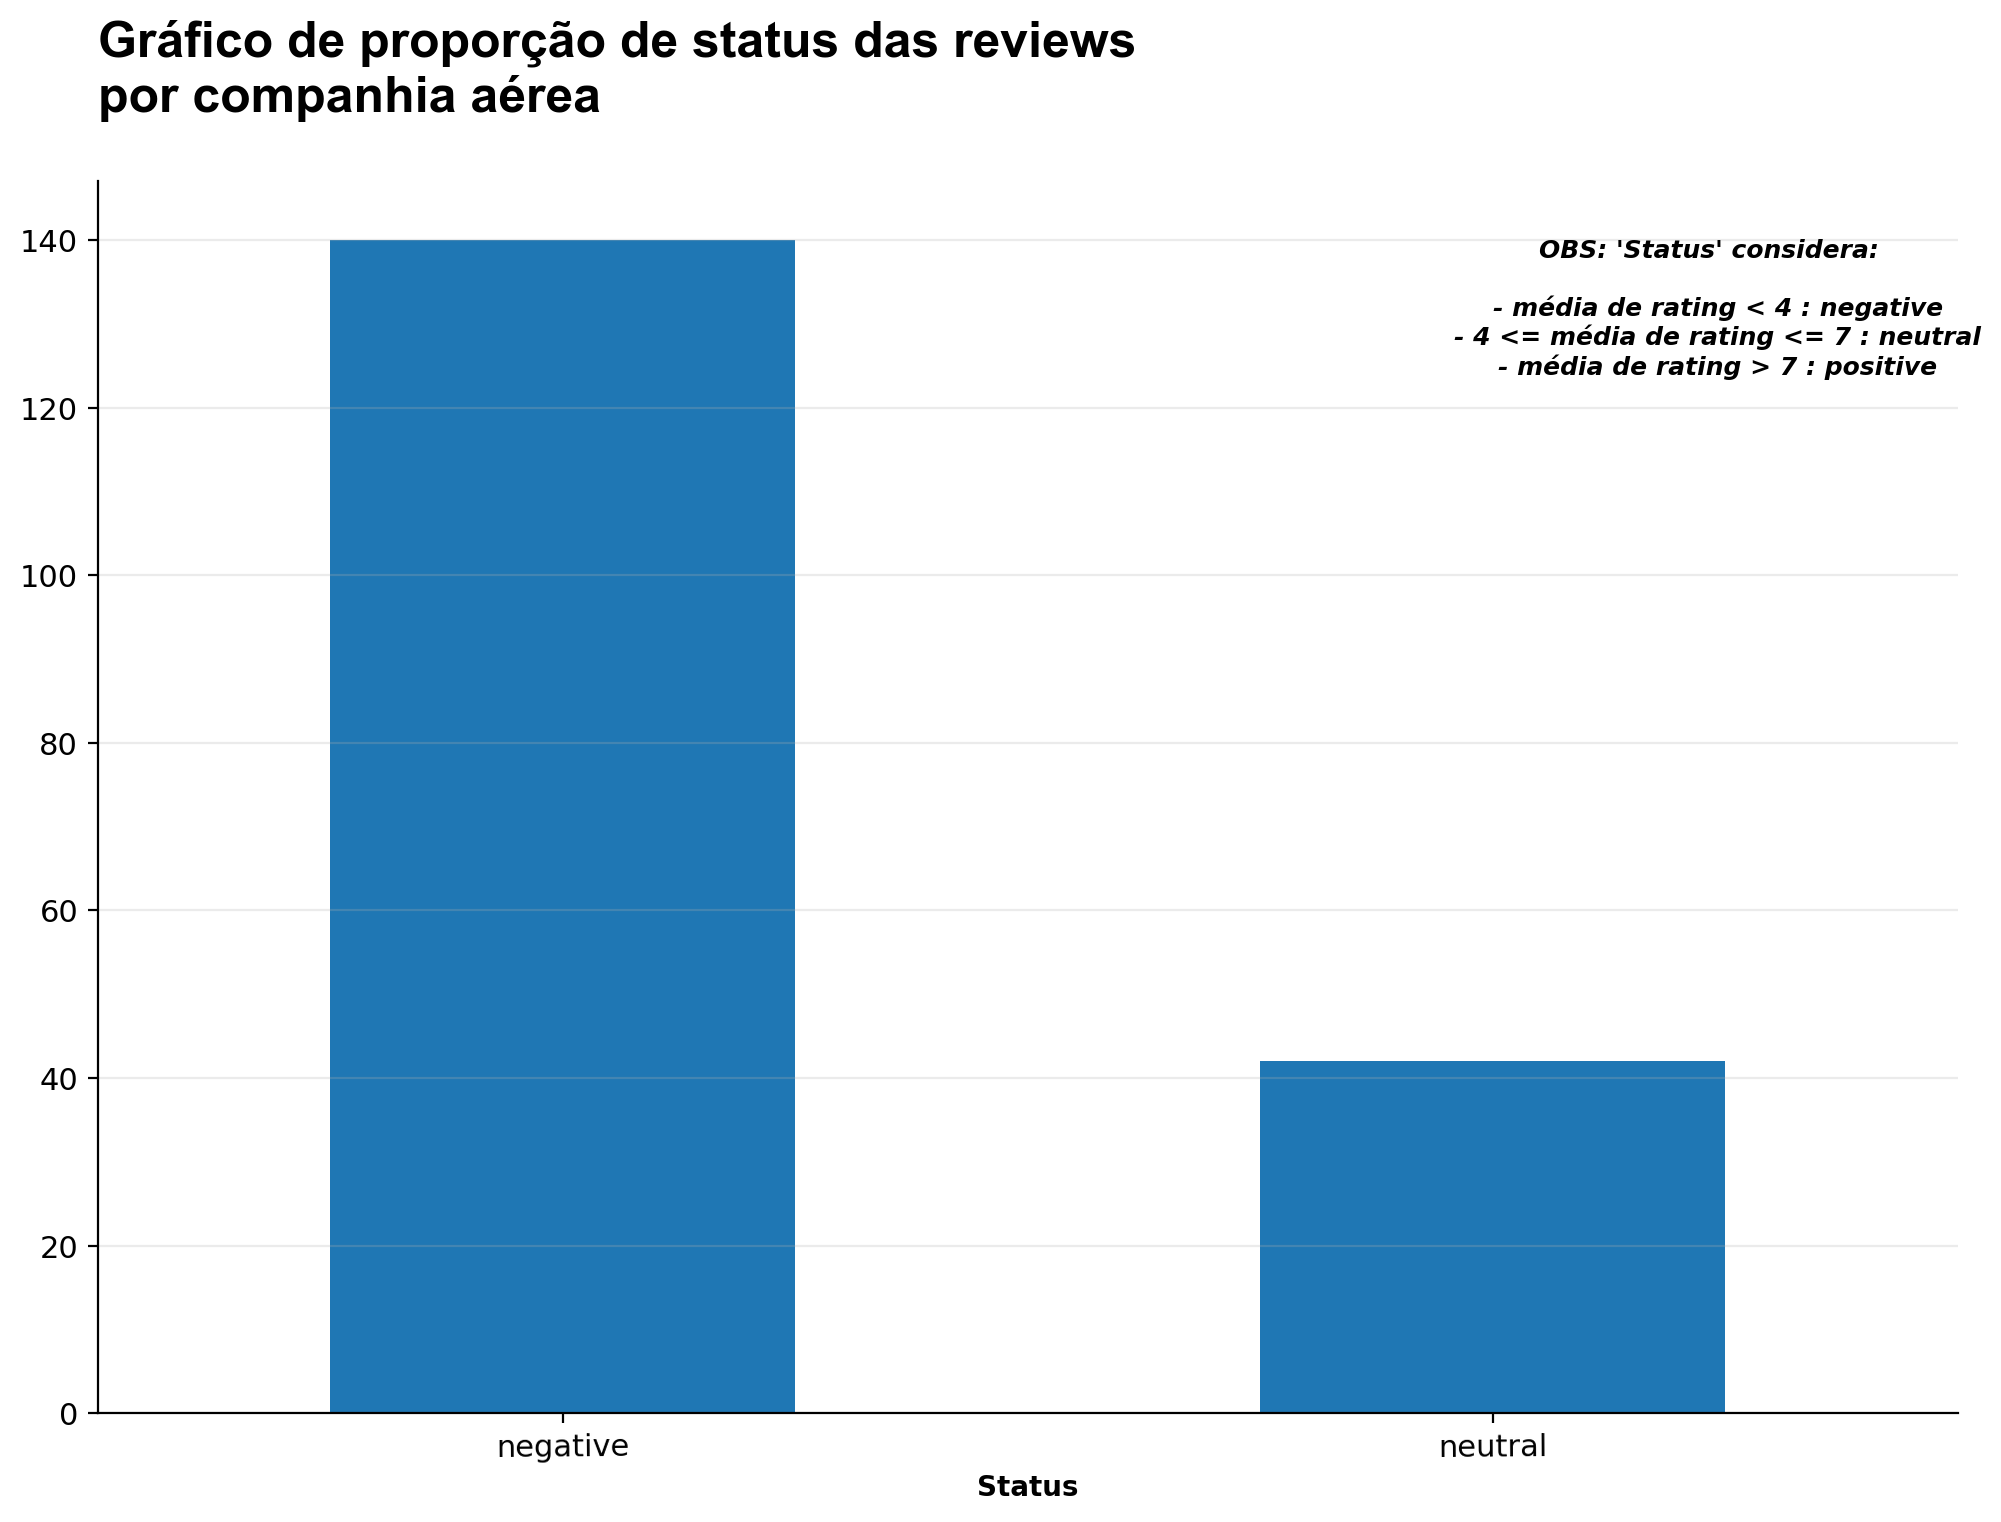

In [46]:
fig, ax = plt.subplots(figsize = (12,8))

df_airline['Status'].value_counts().plot(kind = 'bar', ax = ax)
ax.set_title('Gráfico de proporção de status das reviews \npor companhia aérea\n', loc = 'left', fontsize = 18, fontfamily = 'arial', fontweight = 'bold')
ax.set_ylabel('')
ax.set_xlabel('Status', fontweight = 'bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(True, axis = 'y', alpha = .25)
ax.xaxis.set_tick_params(labelsize = 11, labelrotation = .5)
ax.yaxis.set_tick_params(labelsize = 11)

text = """
OBS: 'Status' considera:  

- média de rating < 4 : negative
- 4 <= média de rating <= 7 : neutral
- média de rating > 7 : positive
"""

fig.text(.8, .8, text, ha = 'center', va = 'center', fontsize = 9, fontweight = 'bold', fontstyle = 'italic')

In [47]:
df_aircraft = \
    df \
        .groupby('Aircraft') \
            .agg(
                mean_rating = ('Overall_Rating', 'mean'), 
                median_rating = ('Overall_Rating', 'median'), 
                count_reviews = ('Overall_Rating', 'count')
            )

df_aircraft['Status'] = np.where(df_aircraft['mean_rating'] < 4, 'negative', np.where((df_aircraft['mean_rating'] >= 4) & (df_aircraft['mean_rating'] <= 7), 'neutral', 'positive'))
df_aircraft

mean_rating  median_rating  count_reviews    Status
Aircraft                                                                     
 A319                          2.0000         2.0000              1  negative
 A321                          2.5000         2.5000              2  negative
-                              1.0000         1.0000              2  negative
1 x Boeing 777, 3 x A380       1.0000         1.0000              1  negative
1429                           1.0000         1.0000              1  negative
...                               ...            ...            ...       ...
bombardier                     1.0000         1.0000              1  negative
dreamliner                     2.0000         2.0000              1  negative
embraer                        2.0000         2.0000              1  negative
unknown                        1.0000         1.0000              1  negative
various                        1.0000         1.0000              1  negative

[836 rows x 4 columns]

In [48]:
df_aircraft['count_reviews'].min(), df_aircraft['count_reviews'].max() 

(np.int64(1), np.int64(12008))

## Verificando distribuição

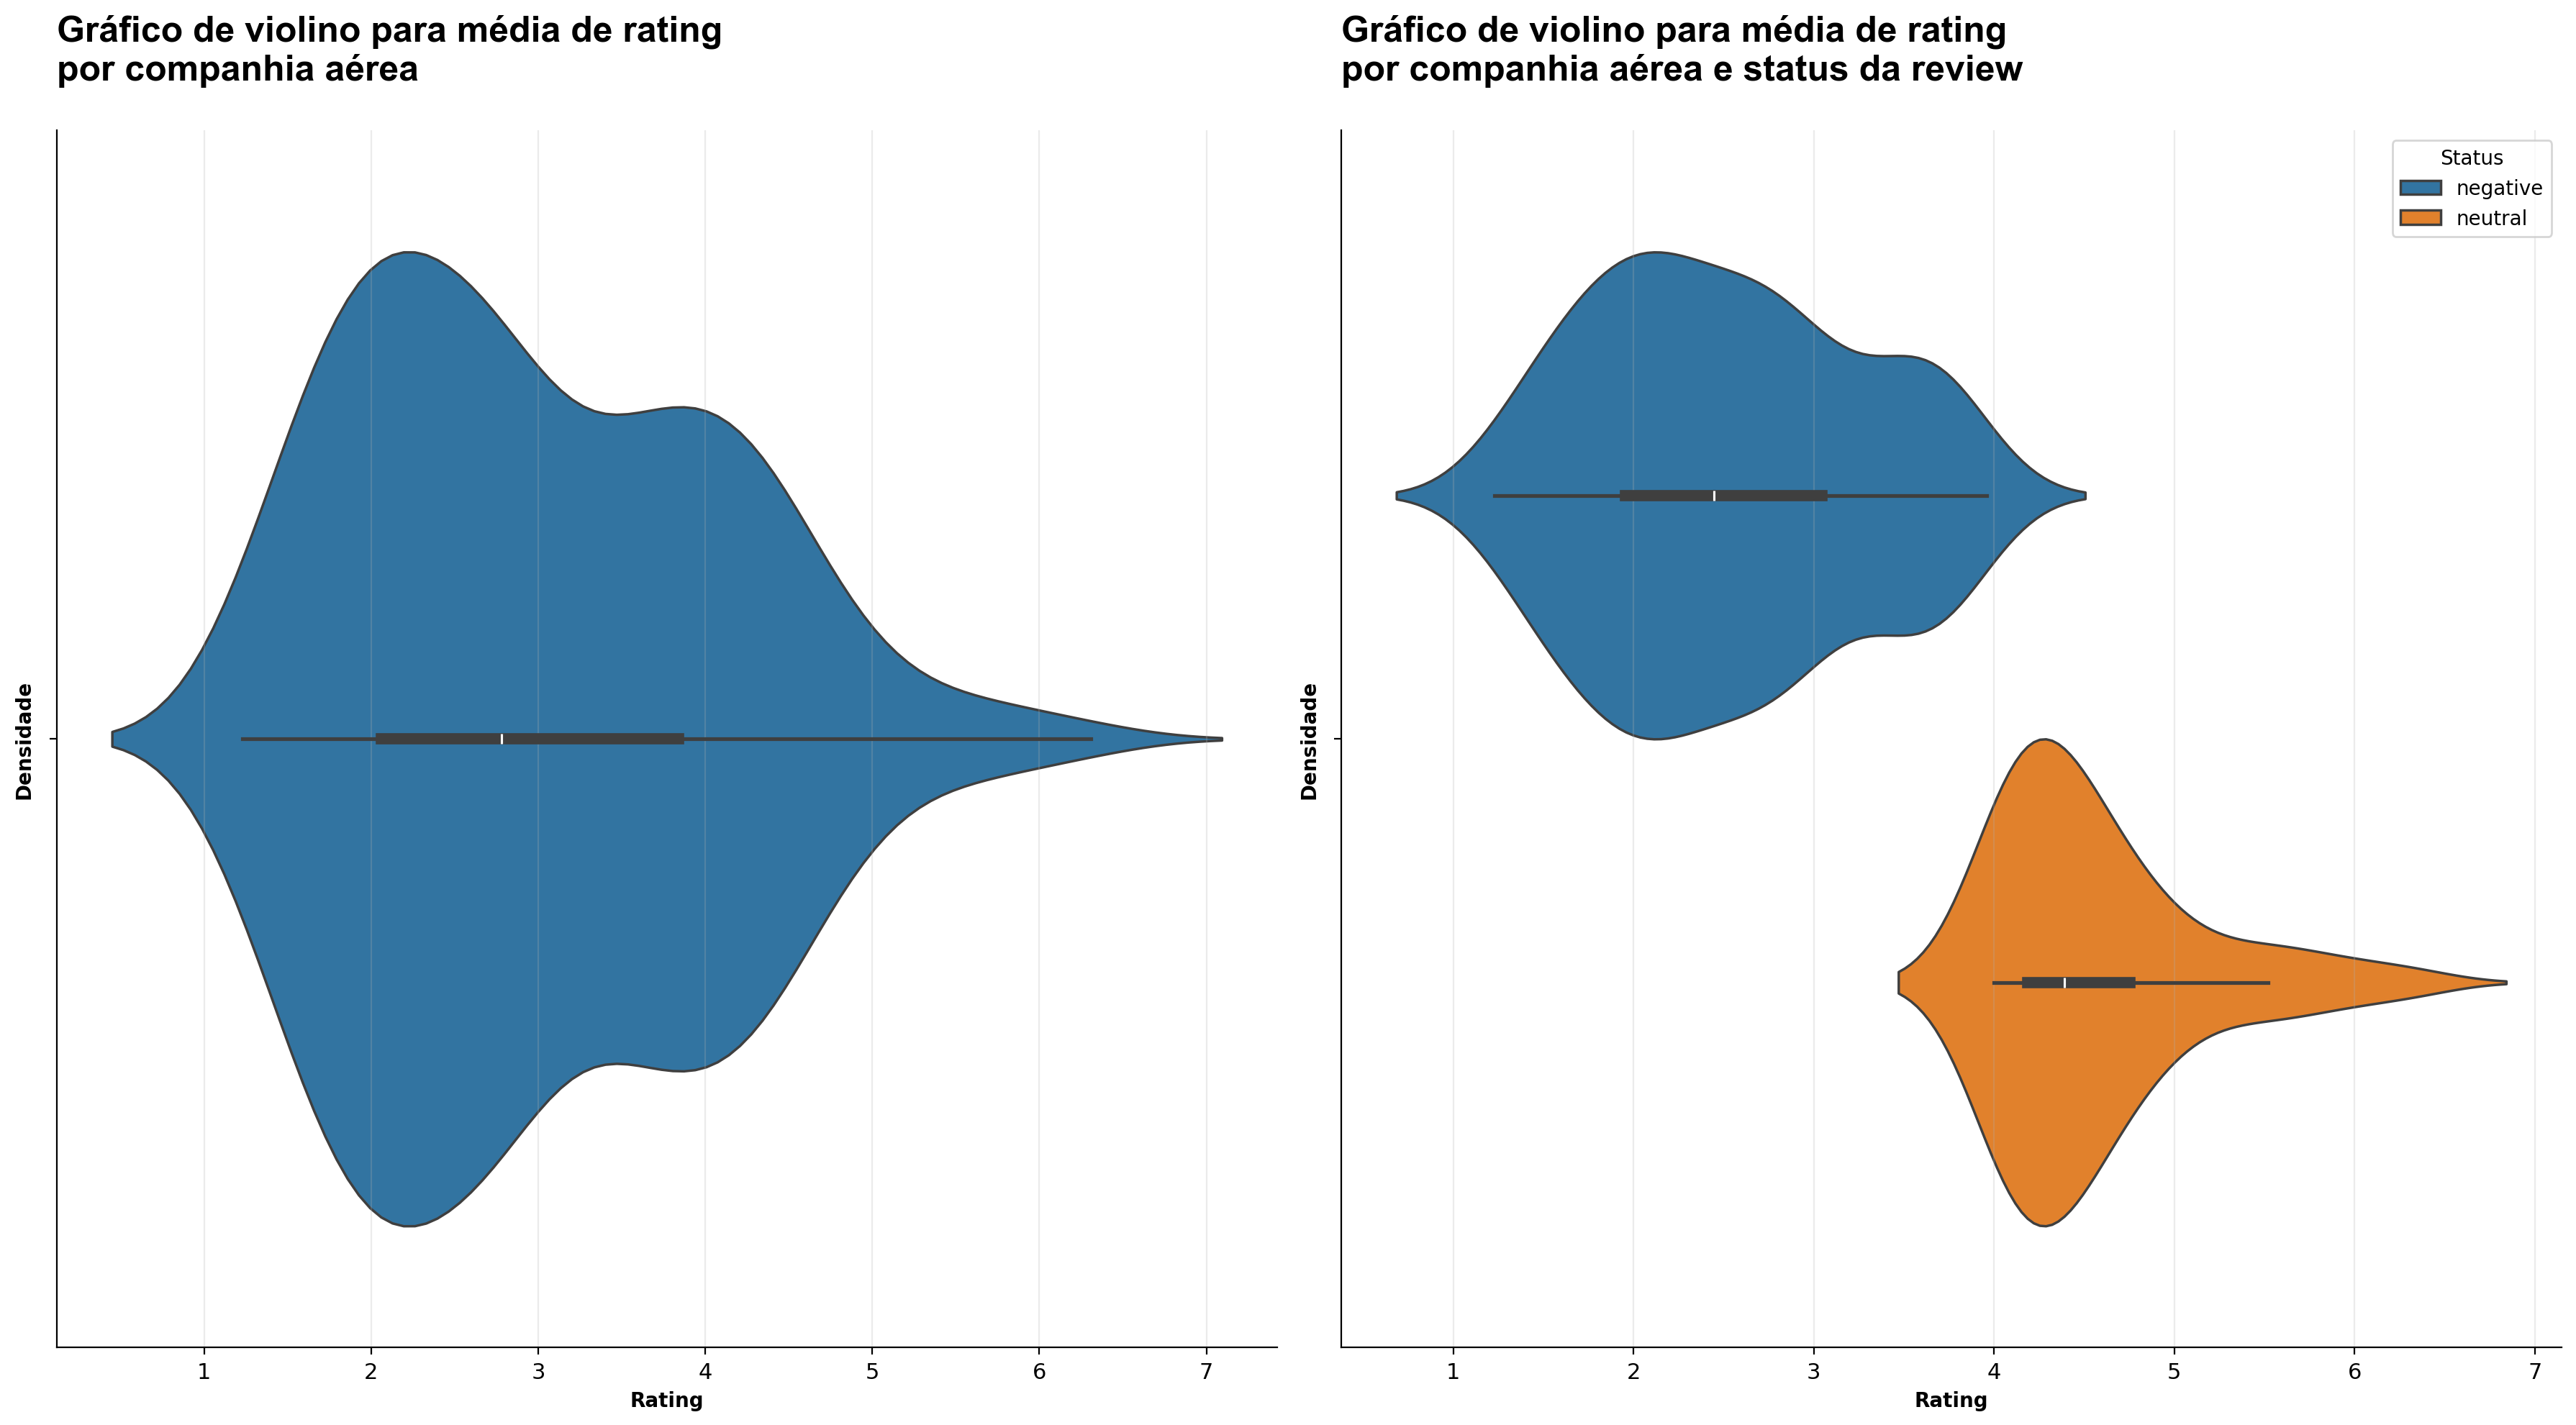

In [49]:
fig, ax = plt.subplots(1,2, figsize = (18,10))

ax[0] = sns.violinplot(data = df_airline, x = df_airline['mean_rating'], ax = ax[0])
ax[0].set_title('Gráfico de violino para média de rating \npor companhia aérea\n', loc = 'left', fontsize = 18, fontfamily = 'arial', fontweight = 'bold')
ax[0].set_ylabel('Densidade', fontweight = 'bold')
ax[0].set_xlabel('Rating', fontweight = 'bold')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].grid(True, axis = 'x', alpha = .25)
ax[0].xaxis.set_tick_params(labelsize = 11)
ax[0].yaxis.set_tick_params(labelsize = 11)



ax[1] = sns.violinplot(data = df_airline, x = df_airline['mean_rating'], hue = 'Status', ax = ax[1])
ax[1].set_title('Gráfico de violino para média de rating \npor companhia aérea e status da review\n', loc = 'left', fontsize = 18, fontfamily = 'arial', fontweight = 'bold')
ax[1].set_ylabel('Densidade', fontweight = 'bold')
ax[1].set_xlabel('Rating', fontweight = 'bold')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].grid(True, axis = 'x', alpha = .25)
ax[1].xaxis.set_tick_params(labelsize = 11)
ax[1].yaxis.set_tick_params(labelsize = 11)

plt.tight_layout()

Nota-se que a distribuição de `Overall_Rating` se concentra mais nos ratings menores quando distribuído sob as companhias aéreas, talvez indicando uma possível associação entre as companhias aéreas com reviews negativos.

In [50]:
df_airline.sample(10)

mean_rating  median_rating  count_reviews    Status
Airline Name                                                        
Allegiant Air         1.4300         1.0000            100  negative
QantasLink            5.9700         8.0000            100   neutral
Alaska Airlines       1.9600         1.0000            100  negative
Kuwait Airways        2.8300         1.0000            100  negative
Air Astana            3.6300         1.0000            100  negative
Qatar Airways         4.0000         3.0000            100   neutral
Volaris               1.2700         1.0000            100  negative
Air Transat           2.1900         1.0000            100  negative
Copa Airlines         2.0500         1.0000            100  negative
Rwandair              4.2308         3.0000             91   neutral

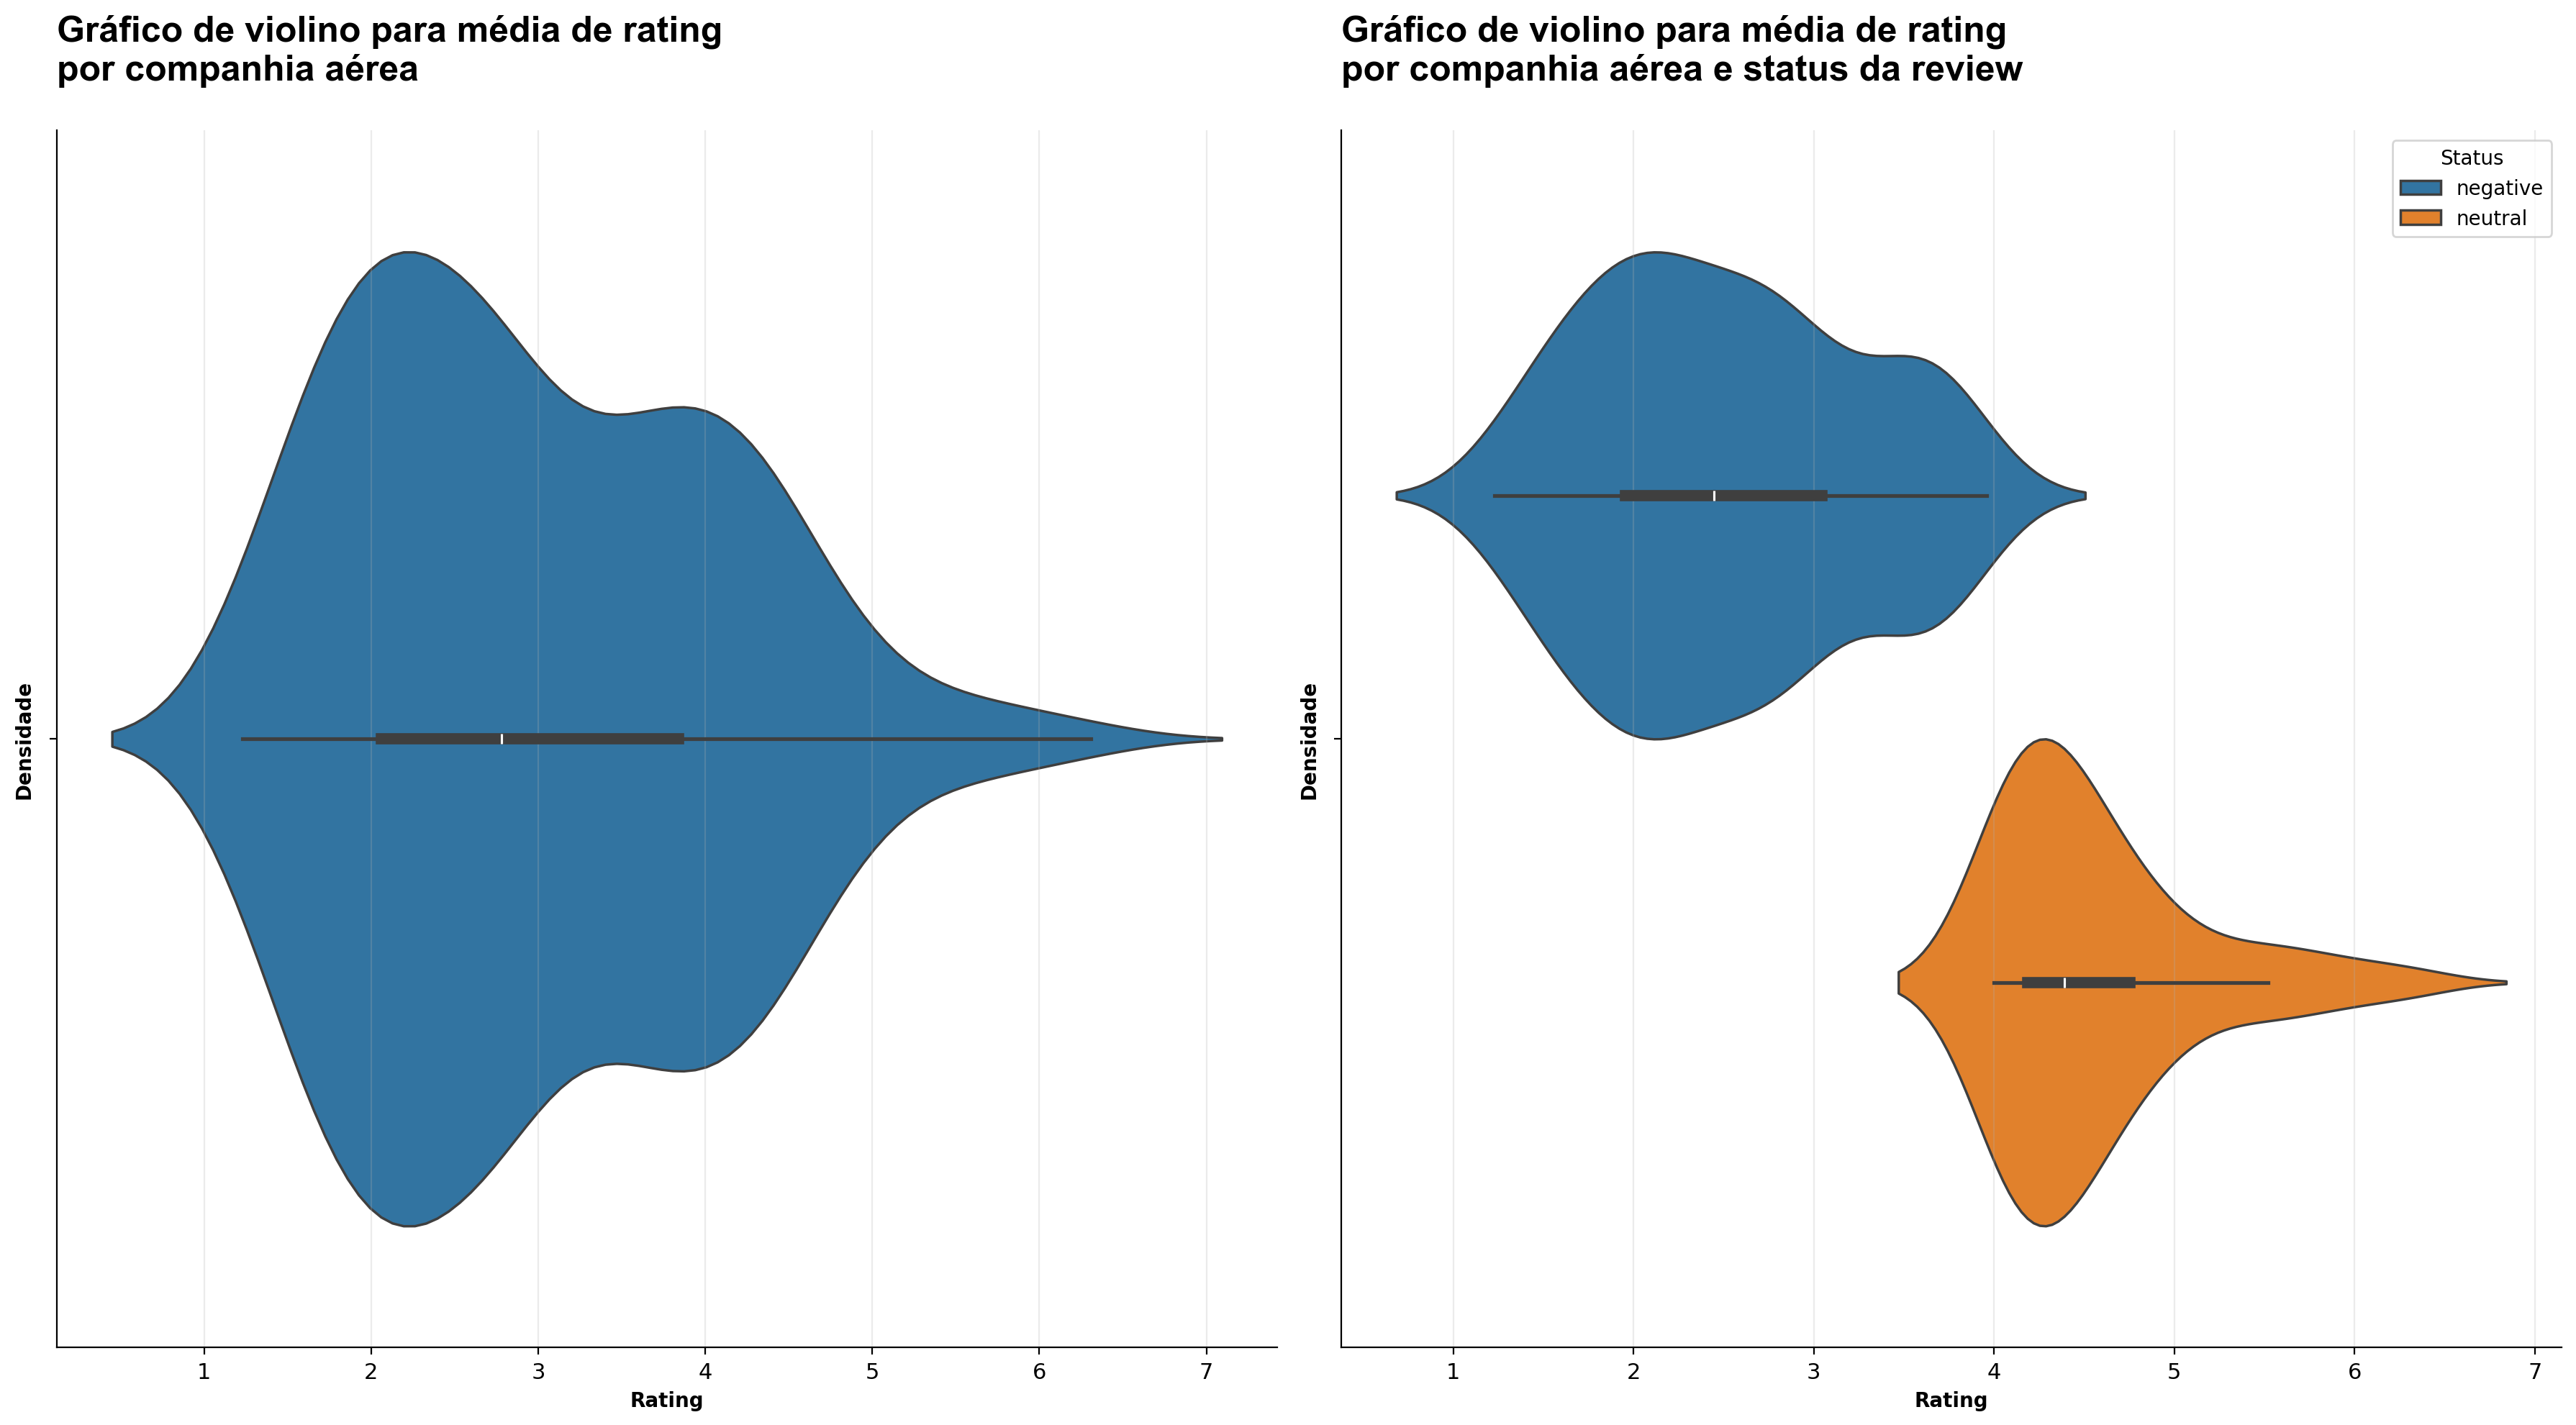

In [51]:
fig, ax = plt.subplots(1,2, figsize = (18,10))

ax[0] = sns.violinplot(data = df_airline, x = df_airline['mean_rating'], ax = ax[0])
ax[0].set_title('Gráfico de violino para média de rating \npor companhia aérea\n', loc = 'left', fontsize = 18, fontfamily = 'arial', fontweight = 'bold')
ax[0].set_ylabel('Densidade', fontweight = 'bold')
ax[0].set_xlabel('Rating', fontweight = 'bold')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].grid(True, axis = 'x', alpha = .25)
ax[0].xaxis.set_tick_params(labelsize = 11)
ax[0].yaxis.set_tick_params(labelsize = 11)



ax[1] = sns.violinplot(data = df_airline, x = df_airline['mean_rating'], hue = 'Status', ax = ax[1])
ax[1].set_title('Gráfico de violino para média de rating \npor companhia aérea e status da review\n', loc = 'left', fontsize = 18, fontfamily = 'arial', fontweight = 'bold')
ax[1].set_ylabel('Densidade', fontweight = 'bold')
ax[1].set_xlabel('Rating', fontweight = 'bold')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].grid(True, axis = 'x', alpha = .25)
ax[1].xaxis.set_tick_params(labelsize = 11)
ax[1].yaxis.set_tick_params(labelsize = 11)

plt.tight_layout()

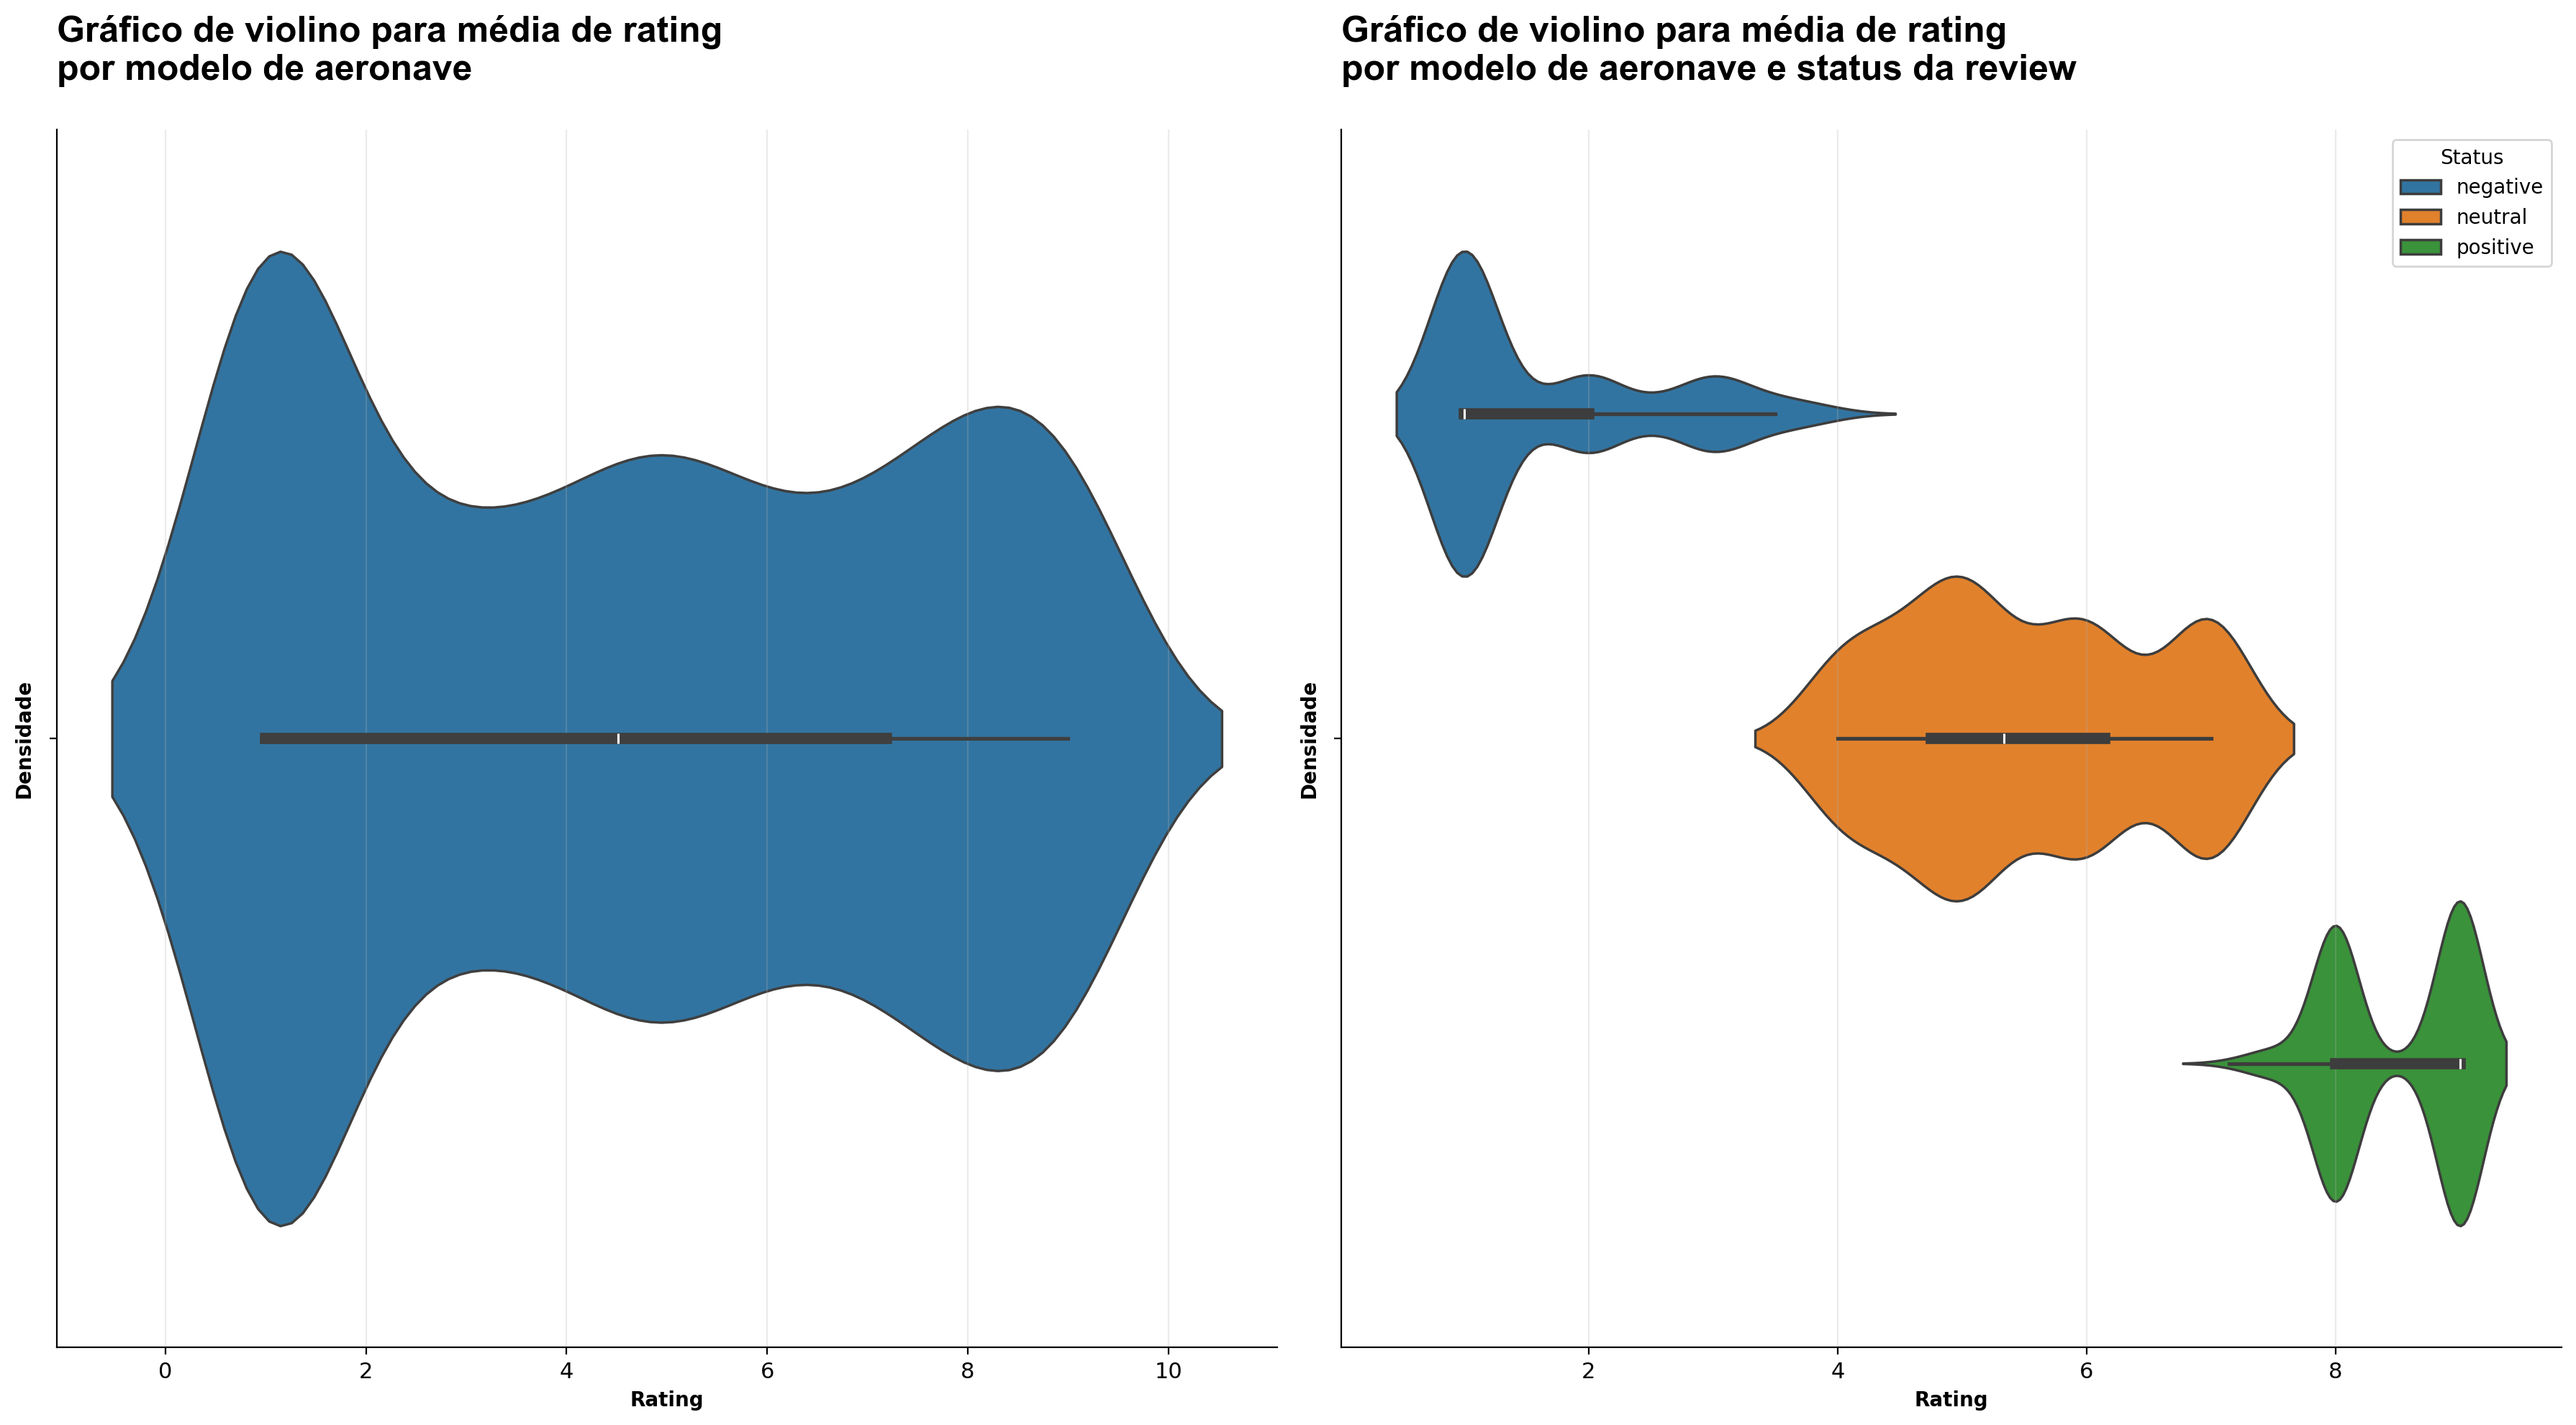

In [52]:
fig, ax = plt.subplots(1,2, figsize = (18,10))

ax[0] = sns.violinplot(data = df_aircraft, x = df_aircraft['mean_rating'], ax = ax[0])
ax[0].set_title('Gráfico de violino para média de rating \npor modelo de aeronave\n', loc = 'left', fontsize = 18, fontfamily = 'arial', fontweight = 'bold')
ax[0].set_ylabel('Densidade', fontweight = 'bold')
ax[0].set_xlabel('Rating', fontweight = 'bold')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].grid(True, axis = 'x', alpha = .25)
ax[0].xaxis.set_tick_params(labelsize = 11)
ax[0].yaxis.set_tick_params(labelsize = 11)



ax[1] = sns.violinplot(data = df_aircraft, x = df_aircraft['mean_rating'], hue = 'Status', ax = ax[1])
ax[1].set_title('Gráfico de violino para média de rating \npor modelo de aeronave e status da review\n', loc = 'left', fontsize = 18, fontfamily = 'arial', fontweight = 'bold')
ax[1].set_ylabel('Densidade', fontweight = 'bold')
ax[1].set_xlabel('Rating', fontweight = 'bold')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].grid(True, axis = 'x', alpha = .25)
ax[1].xaxis.set_tick_params(labelsize = 11)
ax[1].yaxis.set_tick_params(labelsize = 11)

plt.tight_layout()

Já sob a variável `Aircraft`, referente aos modelos da aeronave, a média parece se distribuir mais uniformemente pelo intervalo de rating. Além de mostrar uma boa concentração de ratings positivos, podendo indicar uma associação positiva entre alguns modelos de aeronaves com os reviews positivos.

## Tratamento de texto

In [53]:
df['Review']

0        LHR-SEZ-LHR. It's true that there aren't perso...
1        London City to Antwerp was delayed 3 hours 40 ...
2        PEK to HGH in Economy. Slight delay out of PEK...
3        Rio to Buenos Aires AEP on 737. Departure dela...
4        Outbound flight FRA/PRN A319. 2 hours 10 min f...
                               ...                        
17697     Very poor service. I had to leave to Bahrain ...
17698     Sydney to Gold Coast. Please be aware of the ...
17699     Berlin to Warsaw via Delhi. Try to avoid this...
17700      Volotea is a nice low-cost company, prices a...
17701      Some ladies of the staff from the land of th...
Name: Review, Length: 17673, dtype: object

In [54]:
# nltk.download('stopwords')
# nltk.download('wordnet')

In [55]:
def clean_text(text):
    # Converte o texto para minúsculas
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove menções (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove pontuações e caracteres especiais (exceto espaços)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove números
    text = re.sub(r'\d+', '', text)
    
    # Remove múltiplos espaços em branco
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


# Removendo stopwords utilizando o idioma Inglês
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])


# Redução para radical das palavras usando lemmatização
def apply_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Removendo emojis
def remove_emojis(text):
    return text.encode('ascii', 'ignore').decode('ascii')

# Considerando que a palavra 'not' pode inverter o sentido 
# Por exemplo: "I absolutely loooove this product! It's not bad at all 😊"
# Em casos de uso da palavra 'not', a função marca a próxima palavra e junta como uma única expressão, 
# Exemplo: 'not good' => 'not_good' 

def handle_negation(text):
    negation = "not"
    words = text.split()
    negated_sentence = []
    negate = False
    
    for word in words:
        if word == negation:
            negate = True
        elif negate:
            negated_sentence.append(f"not_{word}")
            negate = False
        else:
            negated_sentence.append(word)
    
    return ' '.join(negated_sentence)


# Removendo textos curtos, com menos de 3 palavras
def remove_short_texts(text, min_length=3):
    return text if len(text.split()) >= min_length else ''


def preprocess_text(text):
    text = handle_negation(text)
    text = clean_text(text)
    text = remove_stopwords(text)
    text = apply_lemmatization(text)
    text = remove_short_texts(text)
    return text

In [56]:
df.insert(5, 'Review_processed', df['Review'].apply(preprocess_text))
df.insert(3, 'Review_Title_processed', df['Review_Title'].apply(preprocess_text))
df.sample(3)

Airline Name  Overall_Rating                       Review_Title  \
13510            Firefly               1            Firefly customer review   
1768      Virgin America               8       "would definitely fly again"   
391    Shanghai Airlines               4  Shanghai Airlines customer review   

                 Review_Title_processed Review_Date_conv  \
13510           firefly customer review       2014-07-31   
1768               would definitely fly       2016-08-13   
391    shanghai airline customer review       2009-05-10   

                                                  Review  \
13510  We flew from Singapore to Subang on 24th July....   
1768     San Diego to Boston via San Francisco with V...   
391    Yichang to Shanghai in April. I had to fly fir...   

                                        Review_processed Aircraft Type Of Traveller  \
13510  flew singapore subang th july everything fine ...  No Info           No Info   
1768   san diego boston via san francisco virgin amer...  No Info      Solo Leisure   
391    yichang shanghai april fly first class economy...  No Info           No Info   

           Seat Type               Route Date_Flown_conv  Seat Comfort  Cabin Staff Service  \
13510  Economy Class             No Info         1900-01             2                    2   
1768   Economy Class  SAN to BOS via SFO         2016-08             4                    4   
391          No Info             No Info         1900-01             2                    2   

       Food & Beverages  Ground Service  Inflight Entertainment  Wifi & Connectivity  \
13510                 2               1                       2                    1   
1768                  3               4                       4                    1   
391                   2               1                       2                    1   

       FoodBeverages_isnan  InflightEntertainment_isnan  WifiConnectivity_isnan  
13510                    1                            1                       1  
1768                     0                            0                       1  
391                      1                            1                       1

## WorldCloud

In [57]:
df.sample()

Airline Name  Overall_Rating                  Review_Title       Review_Title_processed  \
14619  LAN Airlines               5  LAN Airlines customer review  lan airline customer review   

      Review_Date_conv                                             Review  \
14619       2015-06-04  Flew on LA801 from SCL to SYD on 2/6/15. On th...   

                                        Review_processed Aircraft Type Of Traveller  \
14619  flew la scl syd outside lan beautiful aircraft...  No Info           No Info   

           Seat Type    Route Date_Flown_conv  Seat Comfort  Cabin Staff Service  \
14619  Economy Class  No Info         1900-01             1                    3   

       Food & Beverages  Ground Service  Inflight Entertainment  Wifi & Connectivity  \
14619                 1               1                       4                    1   

       FoodBeverages_isnan  InflightEntertainment_isnan  WifiConnectivity_isnan  
14619                    0                            0                       1

In [58]:
def wordcloud(text):
    wc = WordCloud(
        width = 1200,
        height = 400,
        max_words = 100,
        background_color = 'black',
        colormap = 'viridis',
    ).generate(text)

    plt.figure(figsize = (18,8))

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")  

In [59]:
# Definindo dataframes com reviews com ratings mais baixos e os mais altos
df_aux1 = df[df['Overall_Rating'] <= 3]
df_aux2 = df[df['Overall_Rating'] >= 8]


# Concatenando os textos da coluna 'reviews'

texto_aux1 = " ".join(review for review in df_aux1['Review'])
texto_aux2 = " ".join(review for review in df_aux2['Review'])

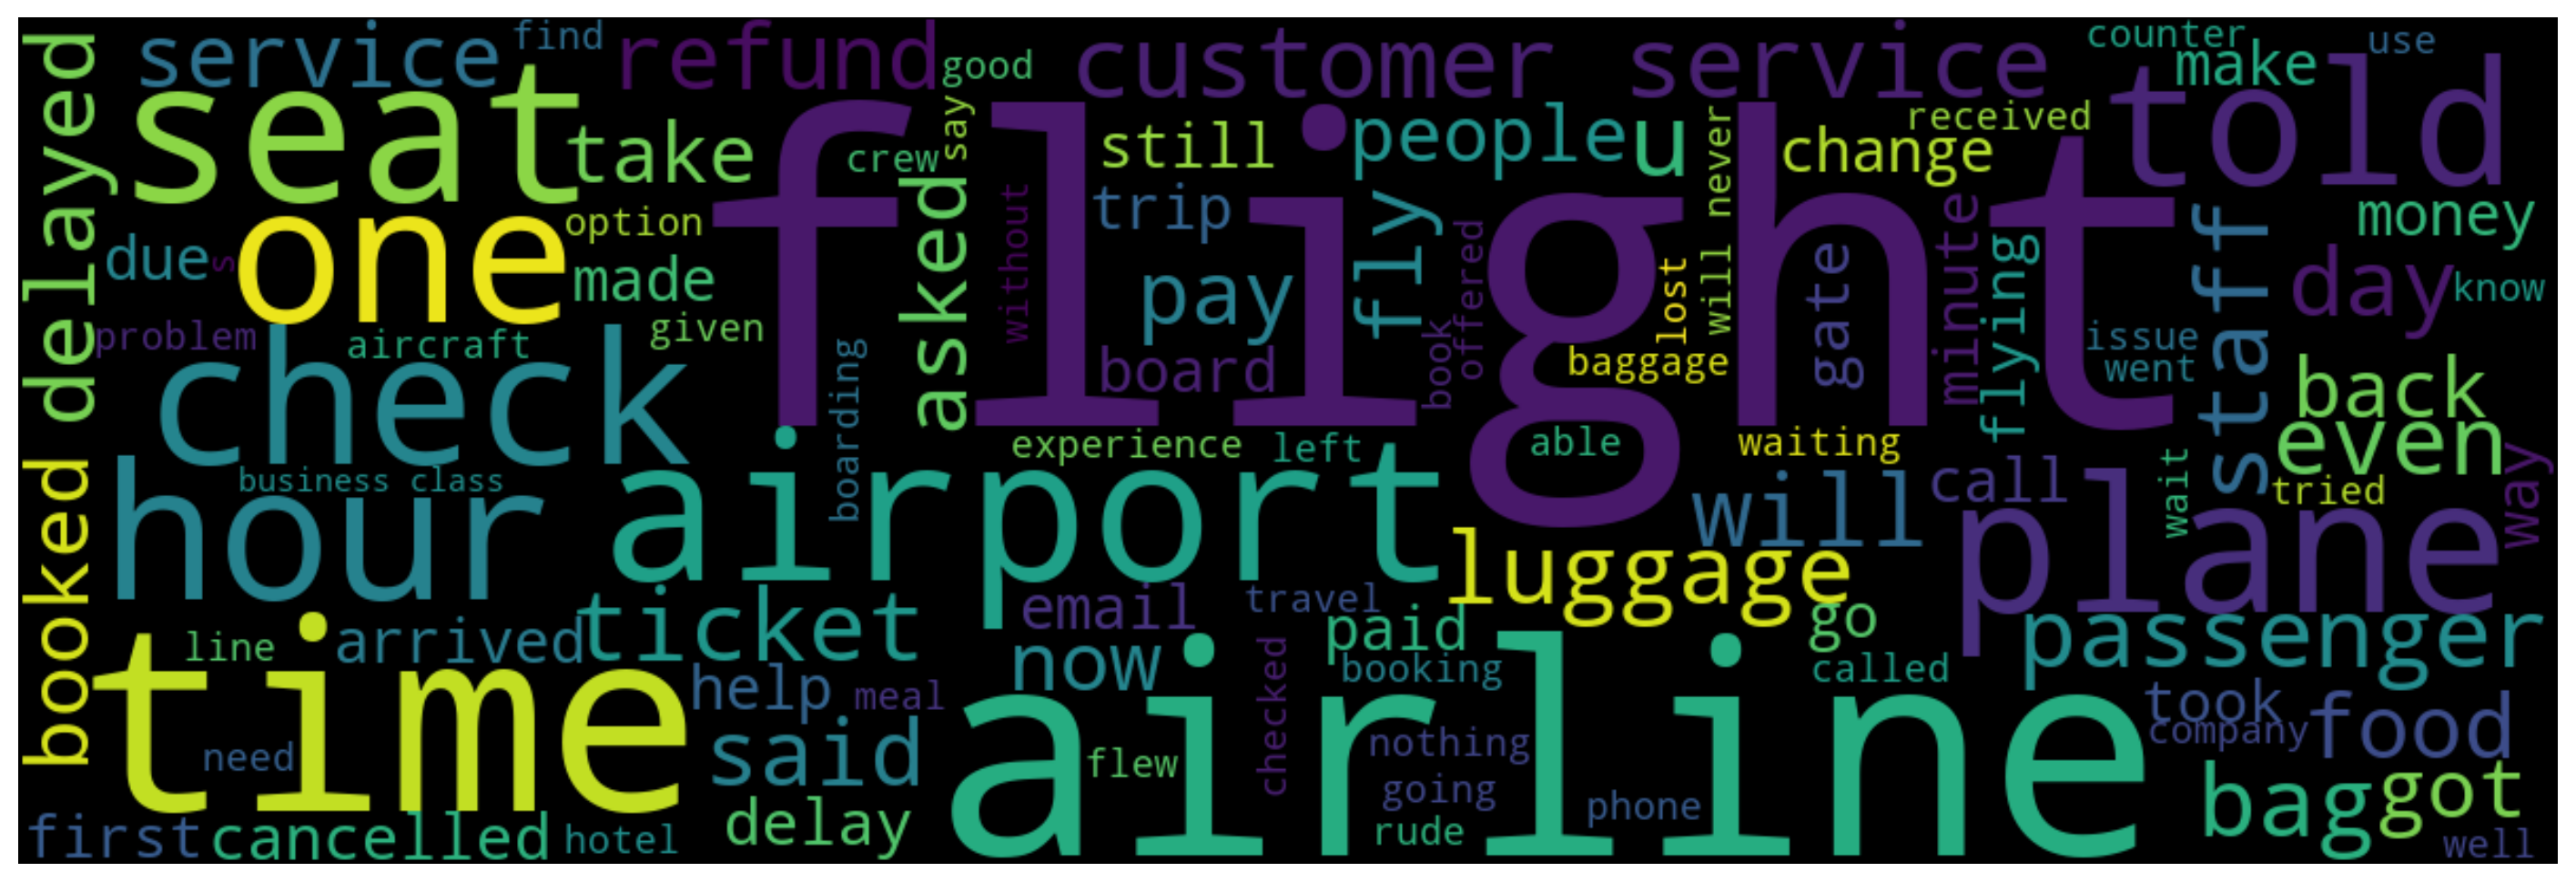

In [60]:
# WordCloud para reviews com ratings mais baixos
wordcloud(texto_aux1)

A partir das palavras na wordcloud das reviews com ratings mais baixos, é possível retirar alguns insights importantes, por exemplo:
- Muitas palavras relacionadas a tempo (`time`, `delayed`, `wait`, `waiting`, `delay`, `hour`), indicando que reviews negativas provavelmente estão associadas a **atrasos em serviços, voos, etc**.
- Coincidentemente, as palavras `customer` e `service` parecem ter a mesma frequência, podendo indicar reviews negativos sobre serviço de **atendimento ao cliente**.

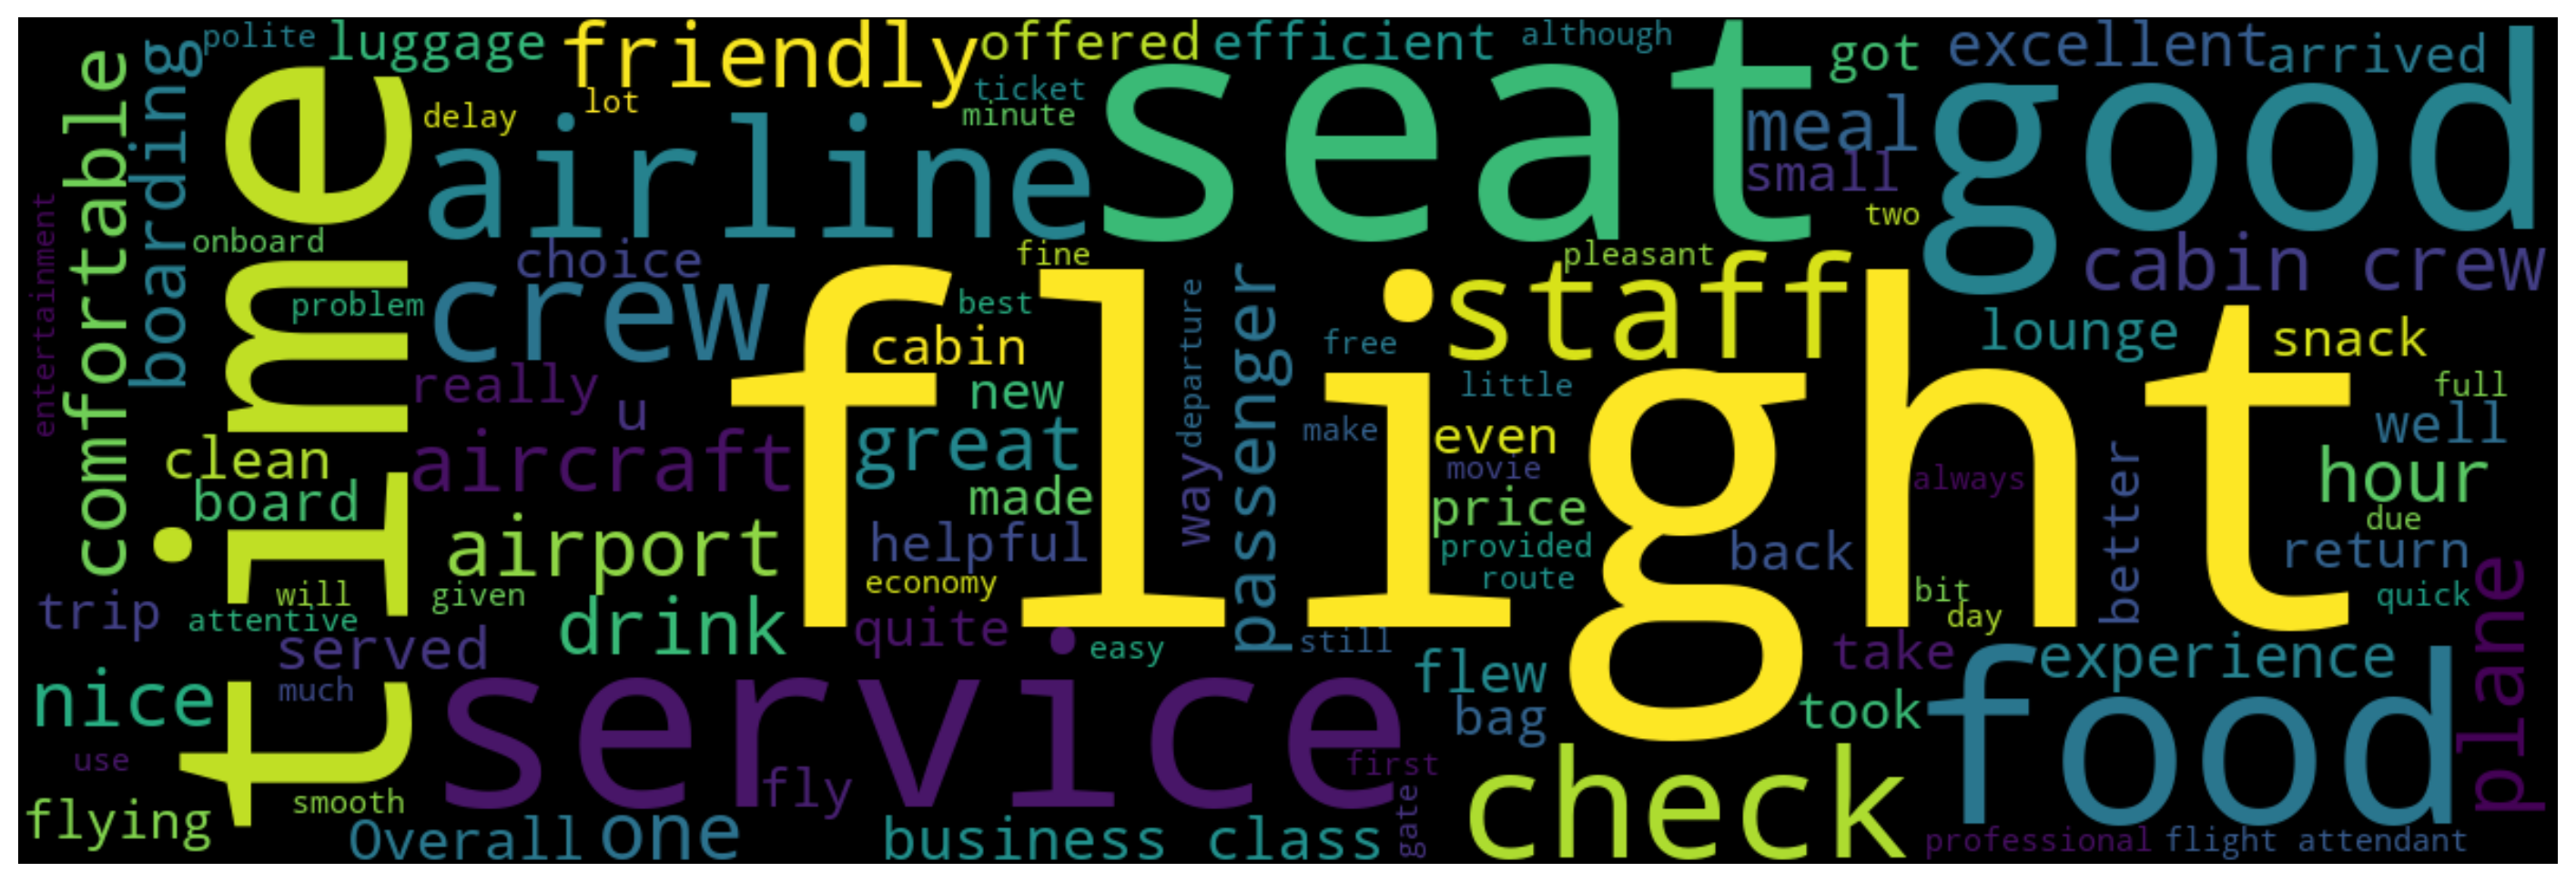

In [61]:
# WordCloud para reviews com ratings mais altos

wordcloud(texto_aux2)

Já na wordcloud de reviews com ratins mais altos vemos destaques como por exemplo:
- Palavras como `friendly`, `crew`,  `service`, `helpful`, `staff` indicam que o serviço e atendimento ao cliente são muito importantes para a avaliação positiva.
- Outro detalhe interessante se dá pela presença de palavras como `plane`, `aircraft`, `comfortable` dão mais indícios de que o modelo da aeronave influencia positivamente em reviews positivos. 

Além disso, **as palavras em comum entre as duas wordclouds podem indicar que a influência desses fatores impactam diretamente experiência do cliente e consequentemente na sua avaliação.**

## Estudo da correlação entre avaliações

In [62]:
cols = ['Overall_Rating', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity']
df_aux = df[cols].copy()

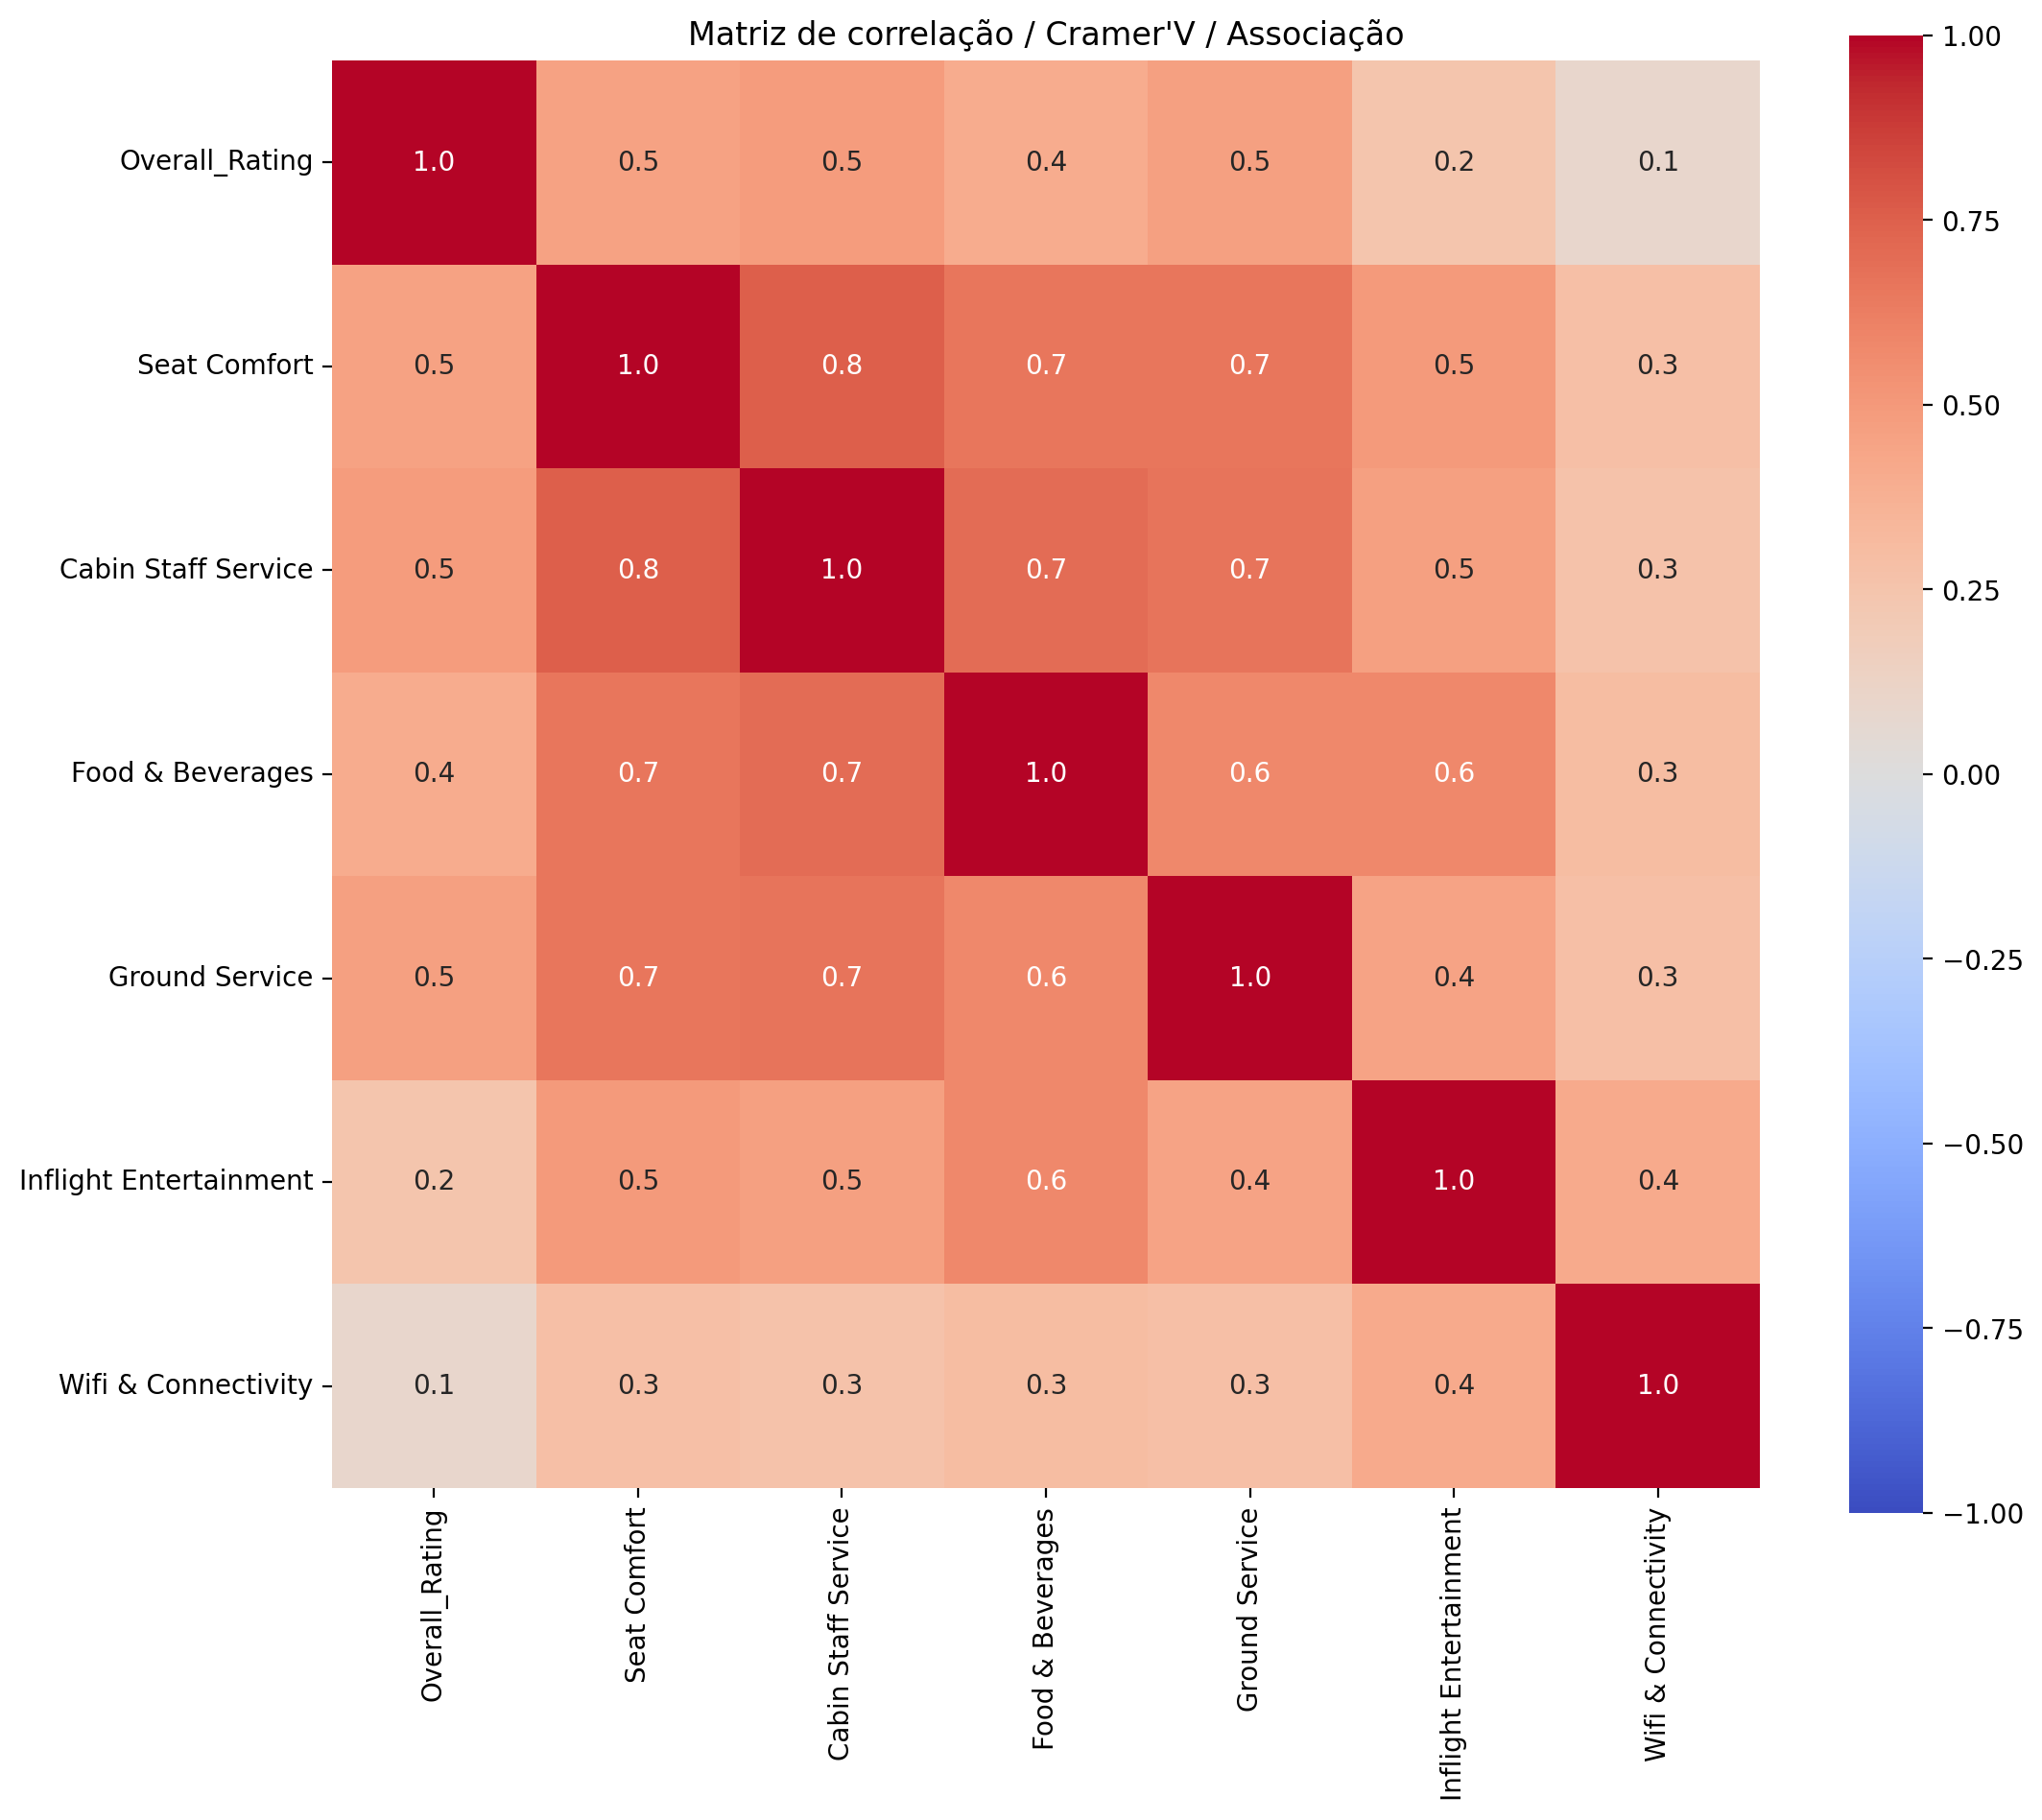

In [63]:
# A função 'associations' de 'dython.nominal' calcula as correlações/associações entre variáveis de todos os tipos
# de acordo com seus respectivos tipos, a configuração padrão que foi utilizada calcula as associações da seguinte forma:
# variável nominal x variável nominal = associação por meio do Cramer's V 
# variável numérica x variável numérica = associação por meio da correlação de pearson
# variável nominal x variável numérica = associação por meio da taxa de correlação
# documentação e fonte: https://shakedzy.xyz/dython/modules/nominal/

d = dython.nominal.associations(
	df_aux,
	figsize = (12, 10),  # Ajusta o tamanho da figura
    annot = True,  # Exibe os números de correlação
    title = "Matriz de correlação / Cramer'V / Associação",
    # annot_kws = {"size": 8},  # Define o tamanho da fonte dos números de correlação
    cmap = "coolwarm",  # Escolhe o colormap
    fmt = ".1f"  # Define o formato dos números de correlação (duas casas decimais)
)

In [64]:
d['corr']

Overall_Rating  Seat Comfort  Cabin Staff Service  Food & Beverages  \
Overall_Rating                  1.0000        0.4560               0.4891            0.4018   
Seat Comfort                    0.4560        1.0000               0.7529            0.6634   
Cabin Staff Service             0.4891        0.7529               1.0000            0.7003   
Food & Beverages                0.4018        0.6634               0.7003            1.0000   
Ground Service                  0.4682        0.6575               0.6702            0.5799   
Inflight Entertainment          0.2482        0.4976               0.4680            0.5786   
Wifi & Connectivity             0.0930        0.2824               0.2643            0.3012   

                        Ground Service  Inflight Entertainment  Wifi & Connectivity  
Overall_Rating                  0.4682                  0.2482               0.0930  
Seat Comfort                    0.6575                  0.4976               0.2824  
Cabin Staff Service             0.6702                  0.4680               0.2643  
Food & Beverages                0.5799                  0.5786               0.3012  
Ground Service                  1.0000                  0.4453               0.2837  
Inflight Entertainment          0.4453                  1.0000               0.4111  
Wifi & Connectivity             0.2837                  0.4111               1.0000

In [65]:
# Verificando multicolinearidade

cols_mult = []
names = []

for col in d['corr'].index:
    corr_values = d['corr'][d['corr'].index == col].drop(columns = col).transpose()[d['corr'][col] >= .75].index
    if len(corr_values) > 0:
        names.append(col)
        cols_mult.append(list(corr_values))

pd.DataFrame({
    'Feature': names,
    'Multicolinearidade com': cols_mult
})    

Feature Multicolinearidade com
0         Seat Comfort  [Cabin Staff Service]
1  Cabin Staff Service         [Seat Comfort]

In [66]:
d['corr']['Overall_Rating'].sort_values(ascending = False)

Overall_Rating           1.0000
Cabin Staff Service      0.4891
Ground Service           0.4682
Seat Comfort             0.4560
Food & Beverages         0.4018
Inflight Entertainment   0.2482
Wifi & Connectivity      0.0930
Name: Overall_Rating, dtype: float64

Como os indícios da wordcloud apontavam, com bastante presença de palavras como `Seat`, `Staff` e `Service`, as variável que mais se correlacionam com `Overall_Rating` são as variáveis `Cabin Staff Service`, `Ground Service`, `Seat Comfort`. Isso quer dizer que essas variáveis impactam positivamente e diretamente o Rating geral. A medida que as notas dessas variáveis cresce, ou seja, quando os clientes estão satisfeitos com esses serviços, o Rating geral tende a ser maior.  
Além disso, `Wifi & Connectivity` foi a variável com a menor correlação, não parecendo impactar tão significativamente o Rating geral.

Também é importante notar que pode haver uma multicolinearidade entre `Seat Comfort` e `Cabin Staff Service`, com uma correlação entre elas de **0.7529**